<a href="https://colab.research.google.com/github/ElenaBinskaya/Sberbank-Russian-Housing-Market/blob/main/Elena_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## download

In [ ]:
from google.colab import files
import os

download  = False if 'kaggle.json' in os.listdir() else True


if download:
  # upload kaggle.json
  files.upload()
  # relocate kaggle.json
  ! mkdir -p ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 /root/.kaggle/kaggle.json      # изменение прав доступ к файлу (необязательная рекомендация от Kaggle)
  ! kaggle competitions download -c sberbank-russian-housing-market
  ! mkdir -p dataset/sberbank-russian-housing-market
  ! wget https://storage.googleapis.com/kaggle-forum-message-attachments/190521/6630/BAD_ADDRESS_FIX.xlsx
  # unzipping
  ! unzip -q train.csv.zip -d dataset/sberbank-russian-housing-market/
  ! rm train.csv.zip
  ! unzip -q test.csv.zip -d dataset/sberbank-russian-housing-market/
  ! rm test.csv.zip
  ! unzip -q macro.csv.zip -d dataset/sberbank-russian-housing-market/
  ! rm macro.csv.zip
  ! unzip -q sample_submission.csv.zip -d dataset/sberbank-russian-housing-market/
  ! rm sample_submission.csv.zip

### Update, concat, merge

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd



plt.rcParams['figure.figsize'] = (12, 6)
sns.set(style='darkgrid', palette='pastel', color_codes=True)

# отключение уведомлений об удалении функций в будущем
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
os.chdir('/content/dataset/sberbank-russian-housing-market/')

train = pd.read_csv('train.csv').set_index('id')       
test = pd.read_csv('test.csv').set_index('id')
df_macro = pd.read_csv('macro.csv')        

In [ ]:
test['part'] = 'test'
train['part'] = 'train'
df=pd.concat([train,test])

df_fix = pd.read_excel('/content/BAD_ADDRESS_FIX.xlsx'). set_index ('id')
df.update(df_fix,overwrite=True)
print(df.shape)
df.tail(3)

(38133, 292)


timestamp  full_sq  life_sq  ...  market_count_5000  price_doc  part
id                                   ...                                    
38133  2016-05-30    41.08      1.0  ...                2.0        NaN  test
38134  2016-05-30    34.80     19.8  ...               10.0        NaN  test
38135  2016-05-30    63.00     43.8  ...               11.0        NaN  test

[3 rows x 292 columns]

# EDA

### Target and missing

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes.value_counts()

float64           275
object             16
datetime64[ns]      1
dtype: int64

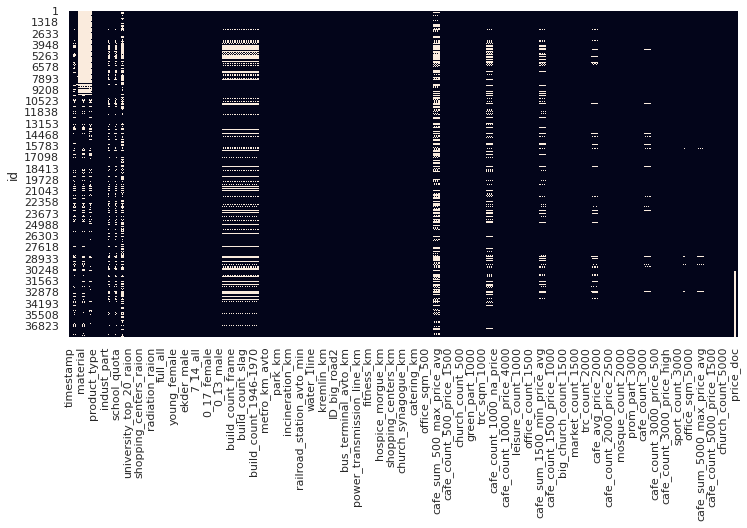

In [ ]:
sns.heatmap(df.isnull(), cbar=False);

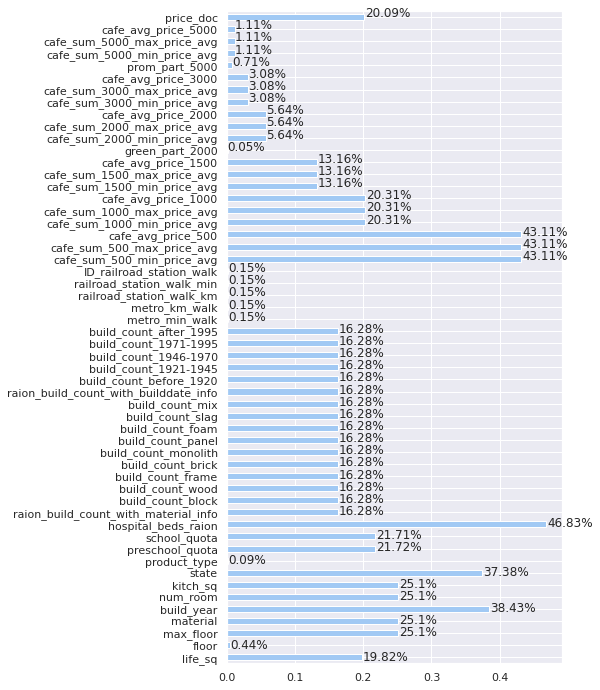

In [ ]:
# https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
plt.figure(figsize=(6,12))
nulls = np.mean(df.isnull())
nulls = nulls[nulls!=0]
ax = nulls.plot(kind='barh')

for p in ax.patches:
    ax.annotate(
        '{}%'.format(round(p.get_width()*100,2)),
        (p.get_width() * 1.005, 
         p.get_y() * 1.005
         ))

In [ ]:
df['price_doc'] = df['price_doc']/1e6

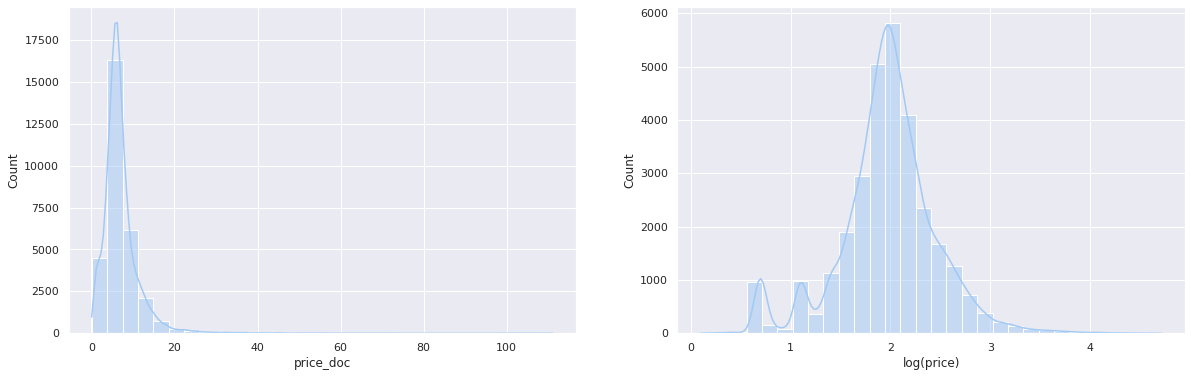

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.histplot(df['price_doc'], kde=True, bins=30)

plt.subplot(122)
sns.histplot(np.log(1+df['price_doc']), kde=True, bins=30)
plt.xlabel('log(price)')

plt.show()


# leave logging after EDA
# df['price_doc']=np.log(df['price_doc'])

In [ ]:
df.describe()

full_sq       life_sq  ...  market_count_5000     price_doc
count  38133.000000  30574.000000  ...       38133.000000  30471.000000
mean      54.111172     34.033460  ...           5.851336      7.123035
std       35.171162     47.581529  ...           4.860571      4.780111
min        0.000000      0.000000  ...           0.000000      0.100000
25%       38.900000     20.000000  ...           1.000000      4.740002
50%       50.000000     30.000000  ...           5.000000      6.274411
75%       63.000000     43.000000  ...          10.000000      8.300000
max     5326.000000   7478.000000  ...          21.000000    111.111112

[8 rows x 275 columns]

In [ ]:
df.describe(include=[np.object])

product_type             sub_area  ... ecology   part
count         38100                38133  ...   38133  38133
unique            2                  146  ...       5      2
top      Investment  Poselenie Sosenskoe  ...    poor  train
freq          24446                 2151  ...   10127  30471

[4 rows x 16 columns]

### flat_features

In [ ]:
def cols_view(cols,figsize=(20,15)):
  plt.figure(figsize=figsize)
  if len(cols)%4==0:
    i=len(cols)/4
    j=4  
  else:
     i=(len(cols)//3)+1
     j=3
  for k,col in enumerate(cols,start=1):
      plt.subplot(i,j,k)
      if df[col].nunique() > 10:
        sns.distplot(df[col])
      else:
        sns.countplot(data=df, x=col)
      pct_missing = np.mean(df[col].isnull())
      if pct_missing != 0:
        plt.title('missing - {}%'.format(round(pct_missing*100,2)))

  plt.tight_layout()
  plt.show()

In [ ]:
flat_features=['timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
               'material', 'build_year', 'num_room', 'kitch_sq', 'state',
               'product_type', 'sub_area']
target=['price_doc']

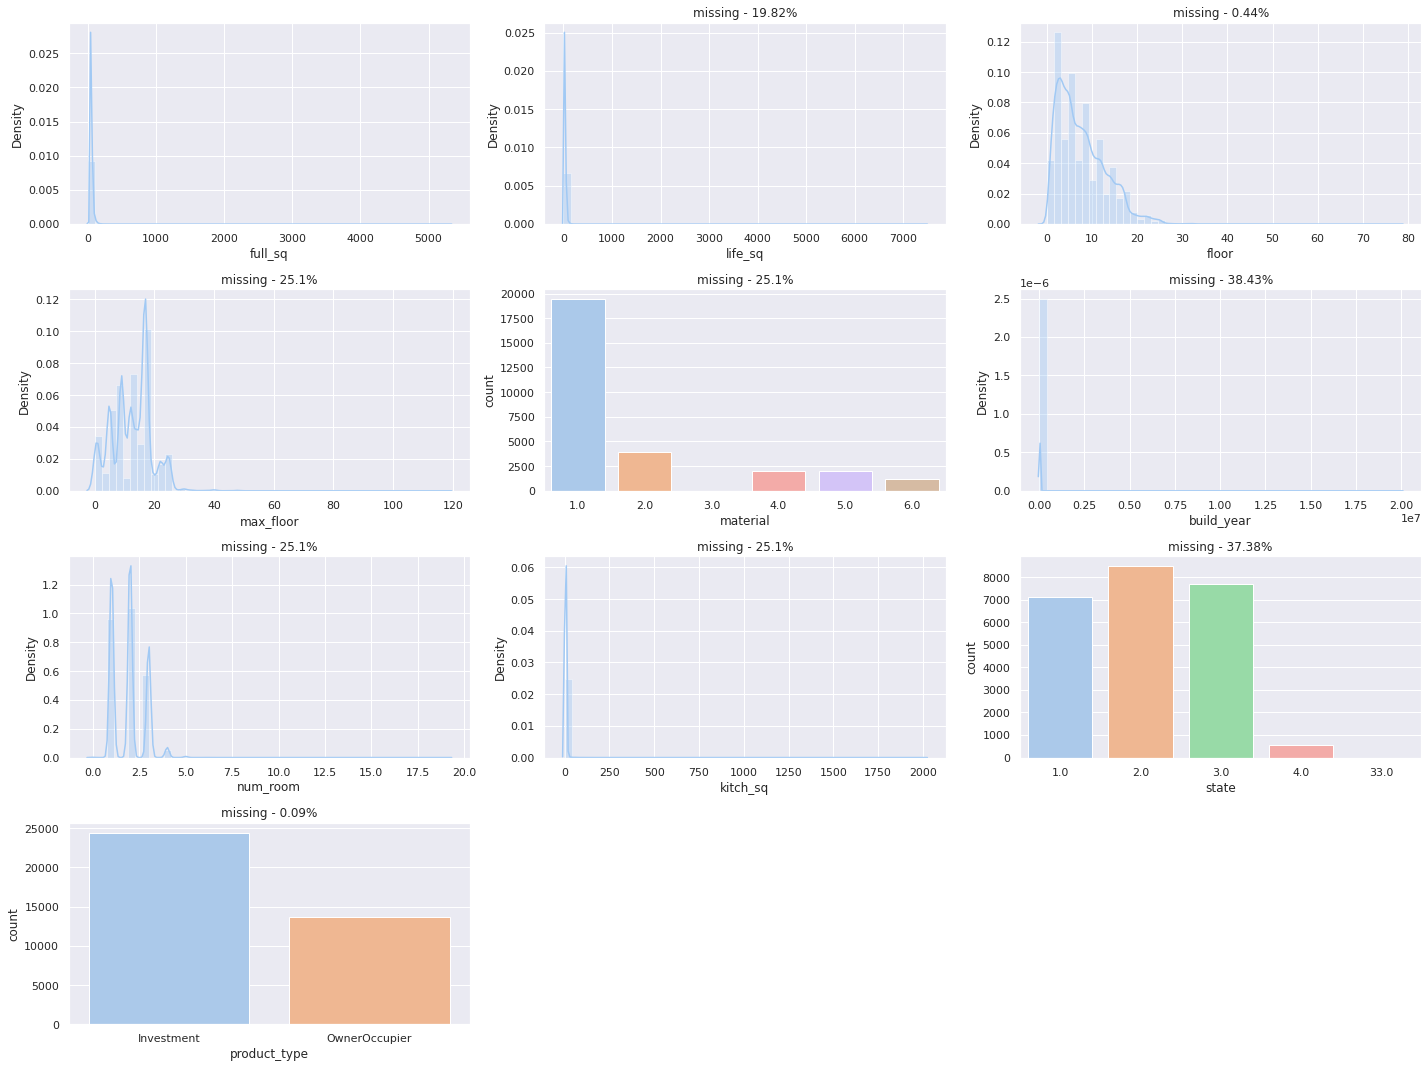

In [ ]:
cols_view(['full_sq', 'life_sq', 'floor', 'max_floor',
               'material', 'build_year', 'num_room', 'kitch_sq', 'state',
               'product_type'])

#### timestamp
дата совершения сделки

In [ ]:
df['year'] = df['timestamp'].dt.year 
df['month_year'] = (df['timestamp'].dt.month + df['timestamp'].dt.year * 100)
#df['month_year'] = (df['timestamp'].dt.month/12 + df['timestamp'].dt.year)

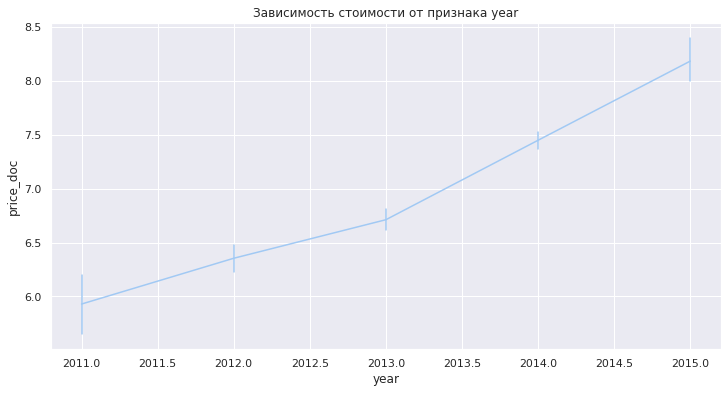

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=df, x='year', y='price_doc', err_style='bars')
plt.title('Зависимость стоимости от признака year')
plt.show()

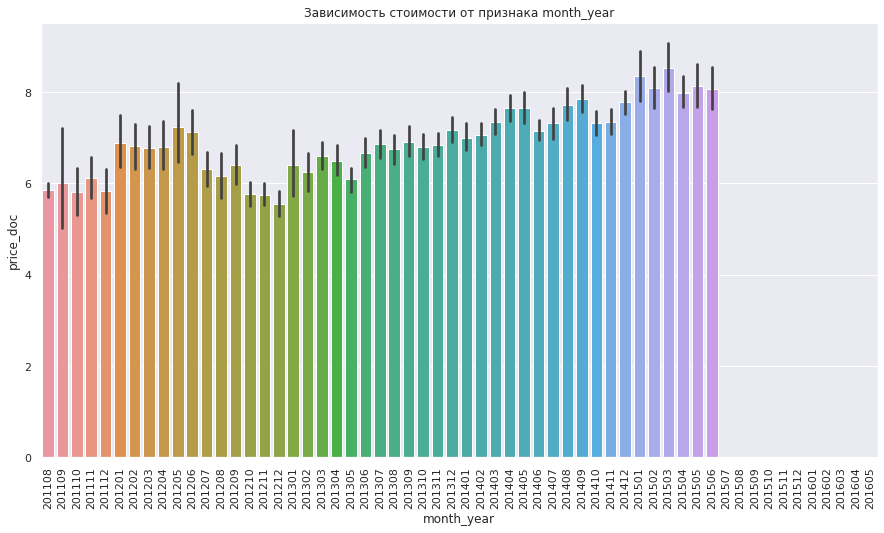

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(data=df, x='month_year', y='price_doc')
# sns.boxplot(data=df, x='month_year', y='price_doc')
#sns.lineplot(data=df, x='month_year', y='price_doc')

plt.title('Зависимость стоимости от признака month_year')
plt.xticks(rotation='vertical')
plt.show()

#### build_year
год постройки

In [ ]:
bad_index = df[(df['build_year'] < 1500) | (df['build_year'] > 2025)].index
df.loc[bad_index, 'build_year'] = np.NaN
df['build_year'] = np.where(df['build_year']<1950, 1949, df['build_year'])
df['build_year'] = df['build_year']

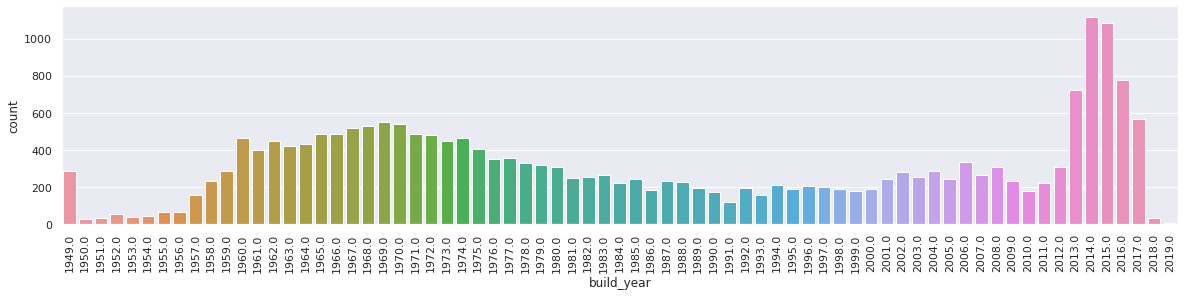

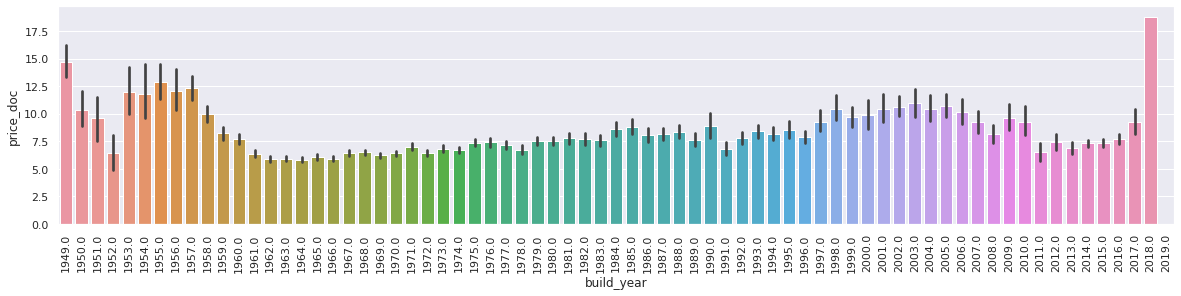

In [ ]:
plt.subplots(figsize=(20,4))
sns.countplot(x='build_year',data=df)
plt.xticks(rotation='vertical')
plt.show()

plt.subplots(figsize=(20,4))
# sns.boxplot(data=df, x='build_year', y='price_doc', showfliers = False)
sns.barplot(data=df, x='build_year', y='price_doc')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# replace nan to sub_area mode/median
# df['build_year'] = df.groupby('sub_area')['build_year'].apply(lambda x: x.fillna(x.mode().iloc[0]))
# df['build_year'] = df.groupby('sub_area')['build_year'].apply(lambda x: x.fillna(x.median()))

df['build_year'] = df['build_year'].fillna(df['build_year'].min()-1).astype(np.int16)

#### state
состояние квартиры

In [ ]:
def des_cat(x, y='price_doc', df=df):

  plt.figure(figsize=(20,6))
  plt.subplot(121)
  sns.countplot(data=df, x=x)

  plt.subplot(122)
  sns.boxplot(data=df, x=x, y=y, showfliers=False)

  plt.show()

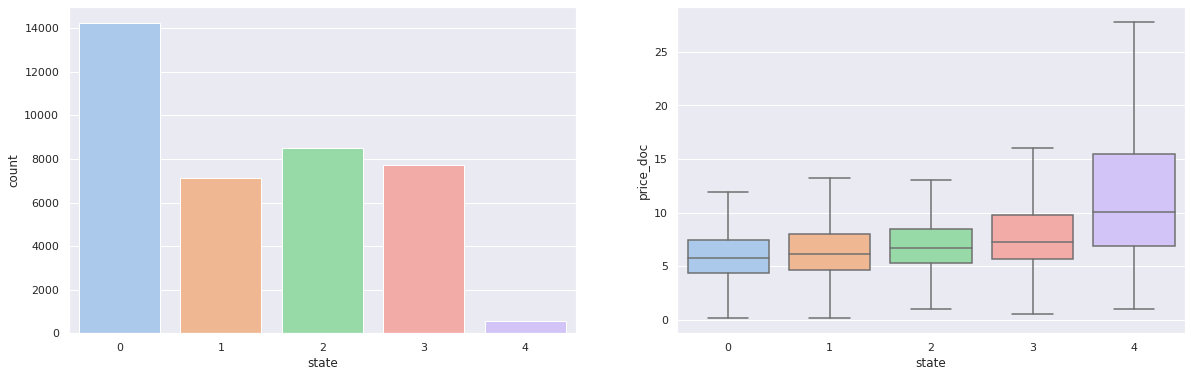

In [ ]:
df['state'].replace(33,3,inplace=True)
df['state']=df['state'].fillna(0).astype(np.int16)


des_cat('state')

#### product_type
продажа квартиры от инвестора или собственника-арендатора

In [ ]:
df[df['part']=='train']['product_type'].value_counts(dropna=False)

Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64

In [ ]:
df[df['part']=='test']['product_type'].value_counts(dropna=False)

Investment       4998
OwnerOccupier    2631
NaN                33
Name: product_type, dtype: int64

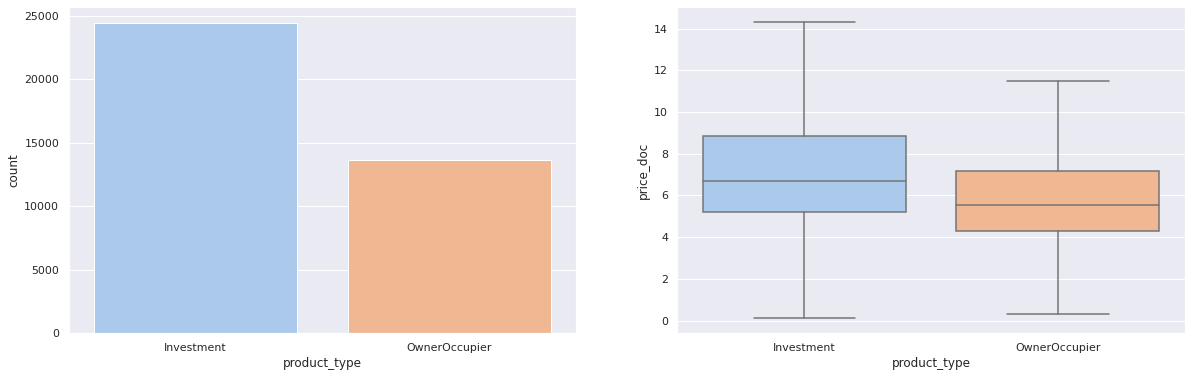

In [ ]:
des_cat('product_type')

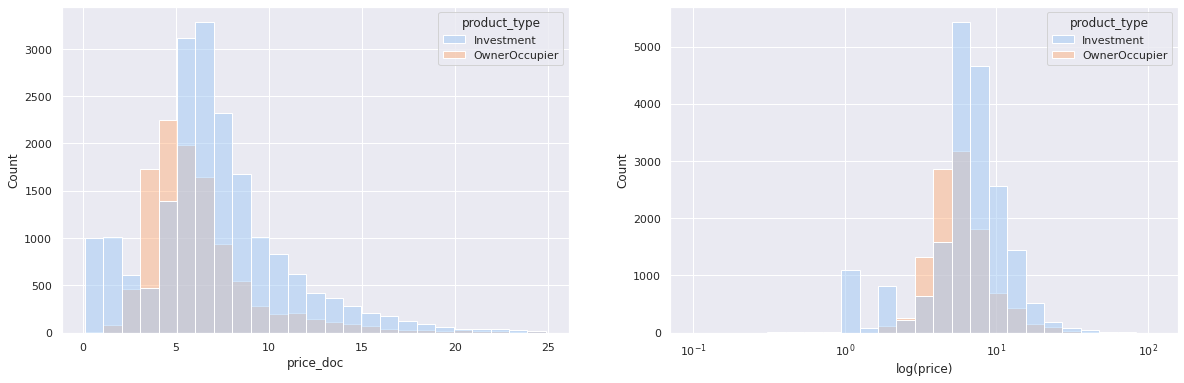

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.histplot(df.query('price_doc < 25'), x='price_doc', kde=False, bins=25, hue='product_type')

plt.subplot(122)
sns.histplot(df, x='price_doc', kde=False, bins=25, log_scale=True, hue='product_type')
plt.xlabel('log(price)')

plt.show()

#### areas (*_sq)
*   **'full_sq'** общая площадь в квадратных метрах, включая лоджии, балконы и другие нежилые помещения
*   **'kitch_sq'**  площадь кухонной зоны
*   **'life_sq'** жилая площадь в квадратных метрах, без учета лоджий, балконов и других нежилых помещений


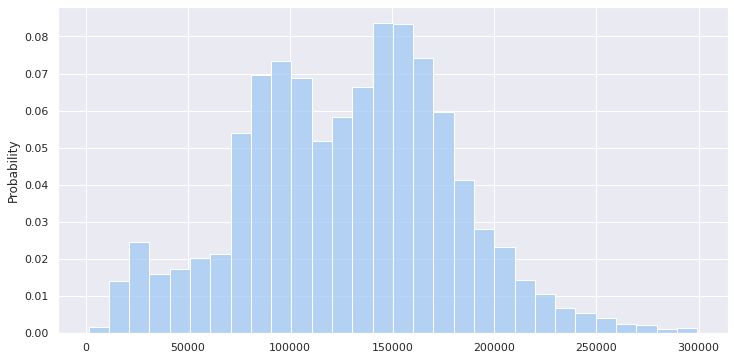

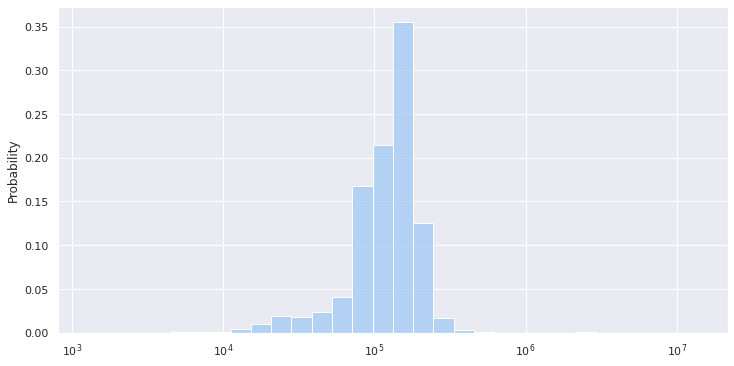

In [ ]:
price_for_meter = df['price_doc']/(df['full_sq']+1)*1e6

sns.histplot(price_for_meter[price_for_meter<3e5], bins=30, stat='probability')
plt.show()

sns.histplot(price_for_meter, log_scale=True, bins=30, stat='probability')
plt.show()

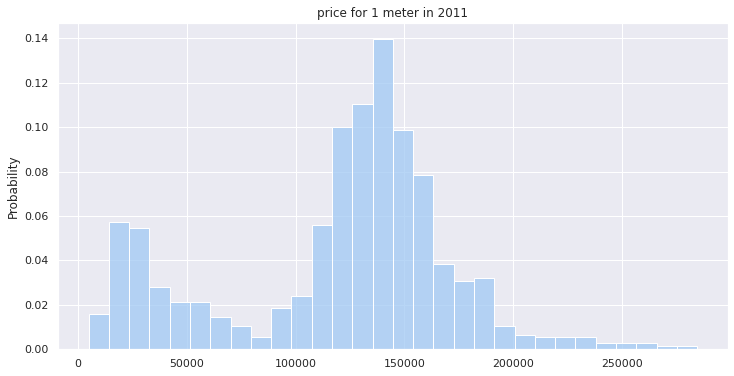

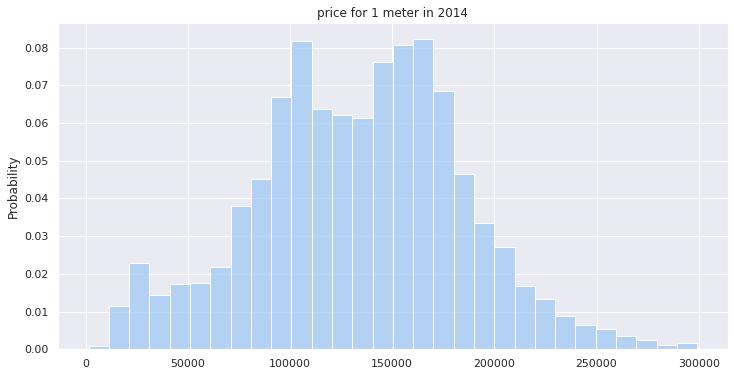

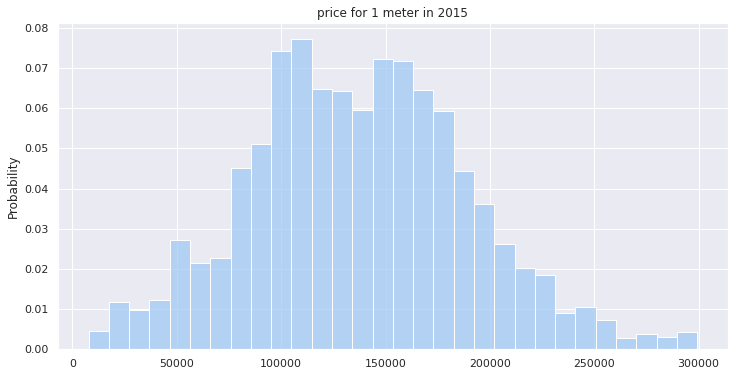

In [ ]:
# https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D0%BC%D0%B0%D0%BD%D1%83%D1%82%D1%8B%D0%B5_%D0%B4%D0%BE%D0%BB%D1%8C%D1%89%D0%B8%D0%BA%D0%B8
# new
for year_cut in [2011,2014,2015]:
  price_for_meter_year_ = df.query(f'year == {year_cut}')['price_doc']/(df.query(f'year == {year_cut}')['full_sq']+1)*1e6

  sns.histplot(price_for_meter_year_[price_for_meter_year_<3e5], bins=30, stat='probability')
  plt.title(f'price for 1 meter in {year_cut}')
  plt.show()


In [ ]:
idx_low_price_for_meter = price_for_meter < 50000
idx_investment = df['product_type']=='Investment'

bad_index = idx_low_price_for_meter & idx_investment

In [ ]:
# слишком дешевые цены от инвестеров
df['suspicious_offer'] = bad_index*1
df.query('part == "train"')['suspicious_offer'].mean()

0.06488136260706902

In [ ]:
# bad_index = df [(df['full_sq'] <5) | (df['full_sq'] > 1000)].index
# df.loc[bad_index, 'full_sq']=np.NaN
# df['full_sq'].fillna(df['full_sq'].min()-1,inplace=True)

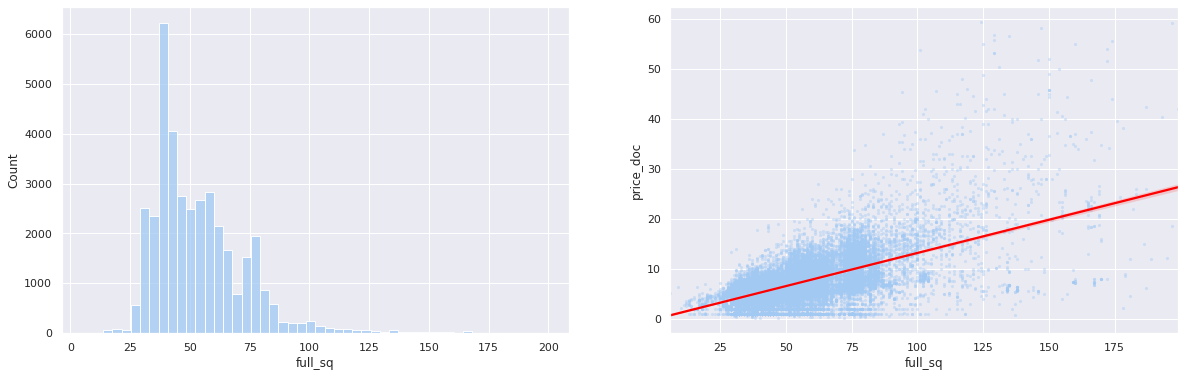

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.histplot(data=df.query('5<full_sq<200'), 
             x='full_sq',bins=50)#, log_scale=True)

plt.subplot(1,2,2)
sns.regplot(data=df.query('5<full_sq<200 & price_doc<60'), 
            x='full_sq', y='price_doc',
            scatter_kws={'alpha': 0.4, 'linewidth':0,'s':10},
            line_kws={'color':'red'})#,logx=True)

plt.show()

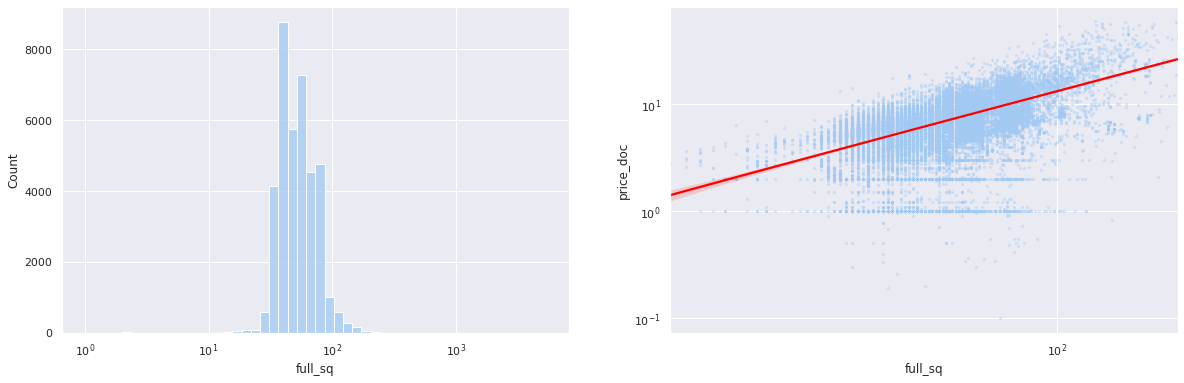

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.histplot(data=df['full_sq']+1, bins=50, log_scale=True)

plt.subplot(1,2,2)
sns.regplot(data=df.query('10<full_sq<200 & price_doc<60'), 
            x='full_sq', y='price_doc',
            scatter_kws={'alpha': 0.4, 'linewidth':0,'s':10},
            line_kws={'color':'red'})#,logx=True)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
sorted(df['kitch_sq'].unique())[-10:]

[112.0, 116.7, 123.0, 620.0, 1000.0, 1968.0, 1970.0, 1974.0, 2013.0, 2014.0]

In [ ]:
sorted(df['life_sq'].unique())[-10:]

[361.0, 407.0, 426.0, 435.0, 458.0, 637.0, 742.0, 802.0, 869.0, 7478.0]

In [ ]:
bad_index = df[(df['kitch_sq']==1968) |
                  (df['kitch_sq']==1970) | 
                  (df['kitch_sq']==1974) |
                  (df['kitch_sq']==2013) |
                  (df['kitch_sq']==2014)].index
df.loc[bad_index, 'build_year']=df['kitch_sq']
df.loc[bad_index, 'kitch_sq']=np.NaN

In [ ]:
bad_index = df[df['life_sq']>df['full_sq']].index
df.loc[bad_index, 'life_sq']=np.NaN
bad_index = df[df['kitch_sq']>df['full_sq']].index
df.loc[bad_index, 'kitch_sq']=np.NaN
bad_index = df[df['kitch_sq']>df['life_sq']].index
df.loc[bad_index, 'kitch_sq']=np.NaN

In [ ]:
bad_index =df [(df['life_sq'] <3) | (df['life_sq'] > 1000)].index
df.loc[bad_index, 'life_sq']=np.NaN
bad_index =df [(df['kitch_sq'] <3) | (df['kitch_sq'] > 1000)].index
df.loc[bad_index, 'kitch_sq']=np.NaN
df['kitch_sq'].fillna(df['kitch_sq'].min()-1,inplace=True)
df['life_sq'].fillna(df['life_sq'].min()-1,inplace=True)

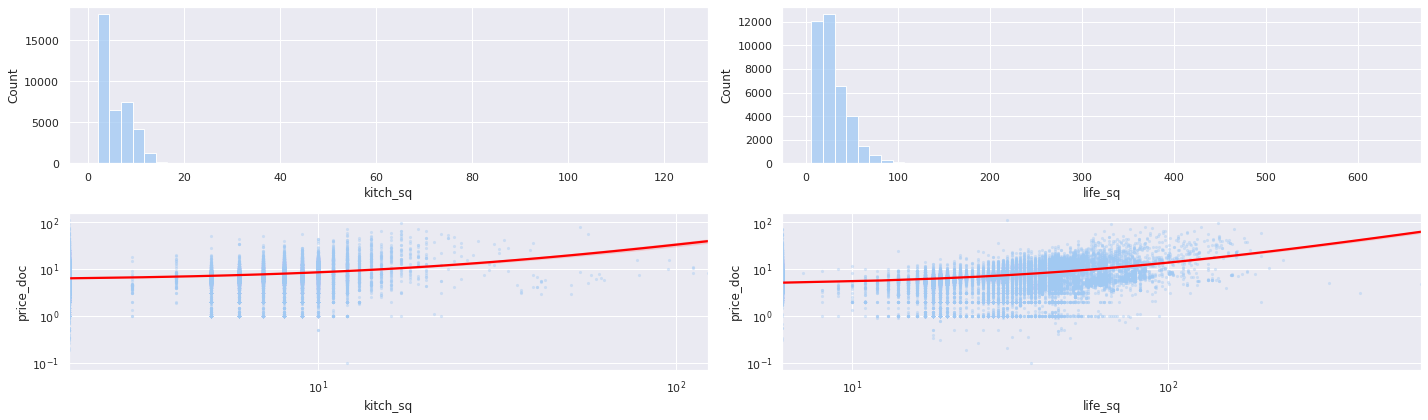

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(2,2,1)
sns.histplot(data=df, x='kitch_sq',bins=50)
plt.subplot(2,2,2)
sns.histplot(data=df, x='life_sq',bins=50)
plt.subplot(2,2,3)
sns.regplot(data=df, x='kitch_sq', y='price_doc',scatter_kws={'alpha': 0.4, 'linewidth':0,'s':10},line_kws={'color':'red'})#,logx=True)
plt.xscale('log')
plt.yscale('log')
plt.subplot(2,2,4)
sns.regplot(data=df, x='life_sq', y='price_doc',scatter_kws={'alpha': 0.4, 'linewidth':0,'s':10},line_kws={'color':'red'})#,logx=True)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

In [ ]:
df['full_sq'] = np.log(1+df['full_sq'])

#### num_room
количество жилых комнат

In [ ]:
df['num_room'].value_counts(dropna=False)

2.0     11229
1.0     10457
NaN      9572
3.0      6229
4.0       551
5.0        59
0.0        14
6.0        10
7.0         3
8.0         3
10.0        2
19.0        2
17.0        1
9.0         1
Name: num_room, dtype: int64

In [ ]:
bad_index =df [(df['num_room'] ==0) | (df['num_room'] >10)].index
df.loc[bad_index, 'num_room']=np.NaN
df['num_room']=df['num_room'].fillna(df['num_room'].min()-1).astype(np.int16)

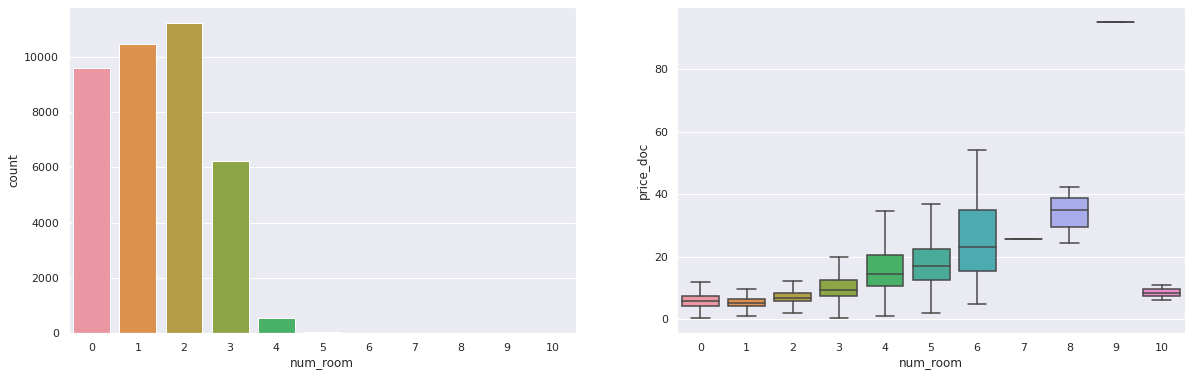

In [ ]:
des_cat('num_room')

#### material
материал стен

In [ ]:
df['material'].value_counts(dropna = False)


1.0    19438
NaN     9572
2.0     3951
5.0     2048
4.0     1963
6.0     1159
3.0        2
Name: material, dtype: int64

In [ ]:
df['material'].fillna(df['material'].min()-1,inplace=True)
df['material'] = df['material'].astype(np.int16).astype(str)

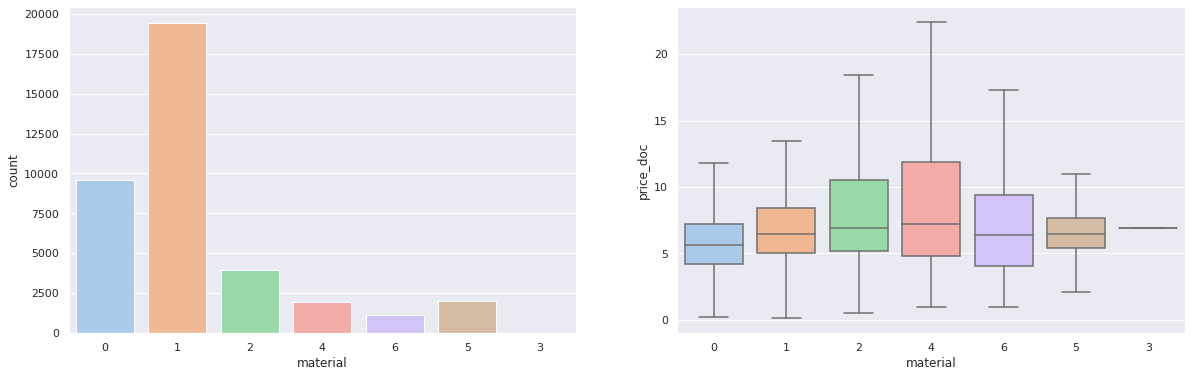

In [ ]:
des_cat('material')

#### floor, max_floor

*  **'max_floor'** количество этажей в здании
*  **'floor'** этаж здания, на котором расположена квартира



In [ ]:
df.loc[df['floor']==0, 'floor']=np.NaN
df.loc[df['max_floor']==0, 'max_floor']=np.NaN
bad_index = df[df['floor']>df['max_floor']].index
df.loc[bad_index, 'max_floor']=np.NaN
# df['floor']=df['floor'].astype(np.int16)
# df['max_floor']=df['max_floor'].astype(np.int16)
df.rename(columns={'floor':'floor_'}, inplace=True)

In [ ]:
# a=0.025
# def regplot(x, y='price_doc', df=df):
#   sns.regplot(data=df.query(f'{df[y].quantile(a/2)}<{y}<{df[y].quantile(1-a/2)} and {df[x].quantile(a/2)}<{x}<{df[x].quantile(1-a/2)}'), 
#             x=x, y=y,scatter_kws={'alpha': 0.4, 'linewidth':0,'s':10},line_kws={'color':'red'})

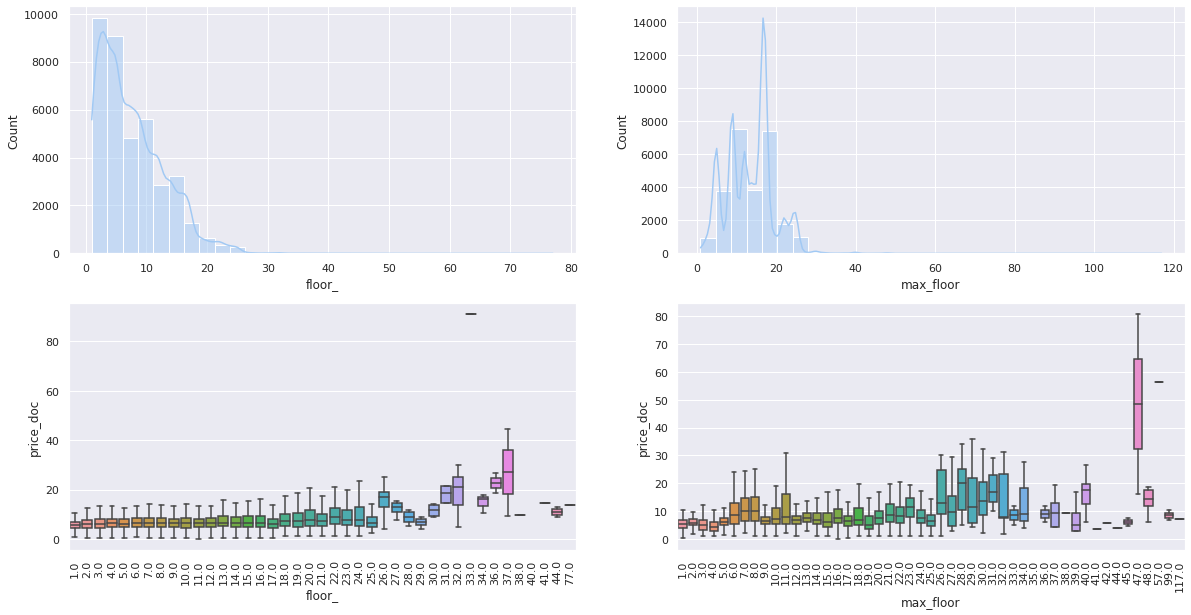

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.histplot(data=df, x='floor_',bins=30, kde=True)
plt.subplot(2,2,2)
sns.histplot(data=df, x='max_floor',bins=30, kde=True)

plt.subplot(2,2,3)
#regplot('floor_')
sns.boxplot(data=df, x='floor_', y='price_doc', showfliers = False)
plt.xticks(rotation='vertical')

plt.subplot(2,2,4)
# regplot('max_floor')
sns.boxplot(data=df, x='max_floor', y='price_doc', showfliers = False)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
def plot_corr_matrix(corr_matrix, figsize=(10,10), fmt='.2f'):
    '''
    corr_matrix: array-like – корреляционная матрица (квадратная, симметричная) 
    figsize: tuple – кортеж с шириной и длинной картинки
    fmt: str – строка определяющая кол-во строк после точки
    '''
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix,
                mask=mask,  # какие числа отображать
                cmap=cmap,  # цветовая гамма
                vmax=1, # максимум корреляции
                vmin=-1, # минимум корреляции
                center=0, # центр корреляции
                square=True, # квадратная ли матрица
                linewidths=.5, # ширина линий между квадратами
                cbar_kws={"shrink": .5}, # уменьшить диаграму сбоку (cbar)
                fmt=fmt, #кол-во знаков после точки
                annot=True # добавить подписи
               )
    plt.show()

#### sub_area
название района

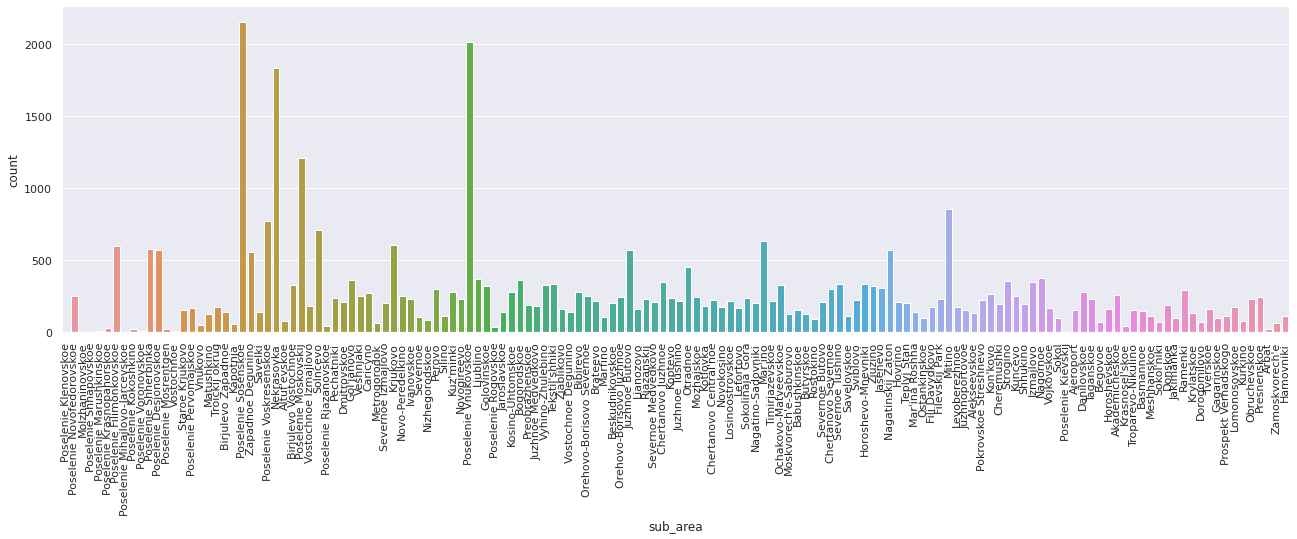

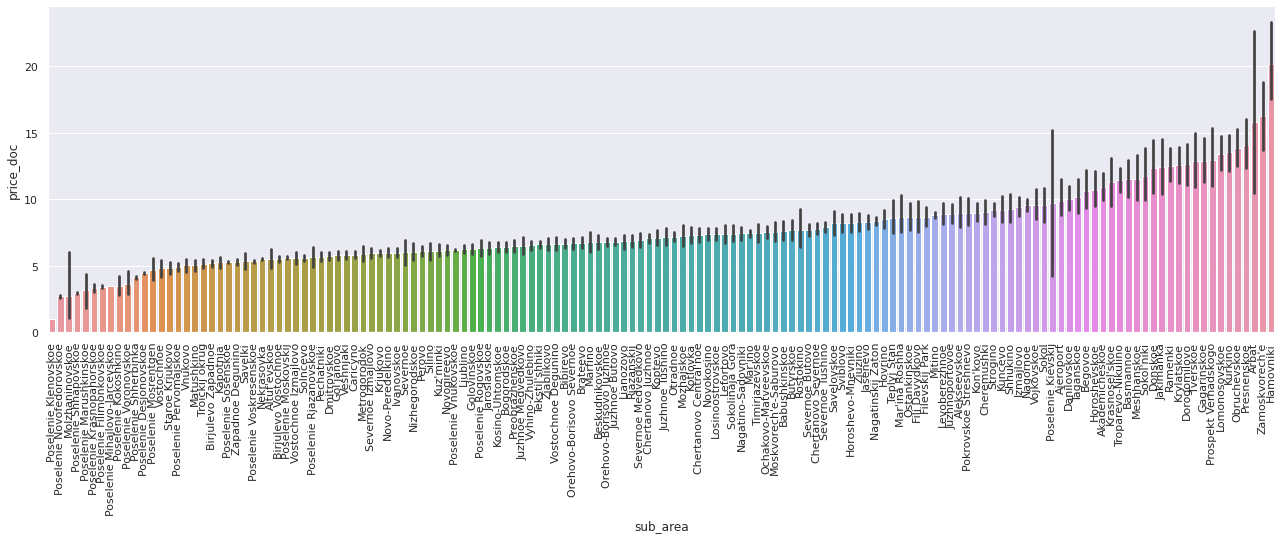

In [ ]:
order = df.groupby('sub_area')['price_doc'].mean().sort_values().index


plt.figure(figsize=(22,6))
sns.countplot(data=df, x='sub_area', order=order)
plt.xticks(rotation = 'vertical')
plt.show()

plt.figure(figsize=(22,6))
# sns.boxplot(data=df, x='sub_area',y='price_doc', order=order, showfliers=False)
sns.barplot(data=df, x='sub_area',y='price_doc', order=order)
plt.xticks(rotation = 'vertical')
plt.show()

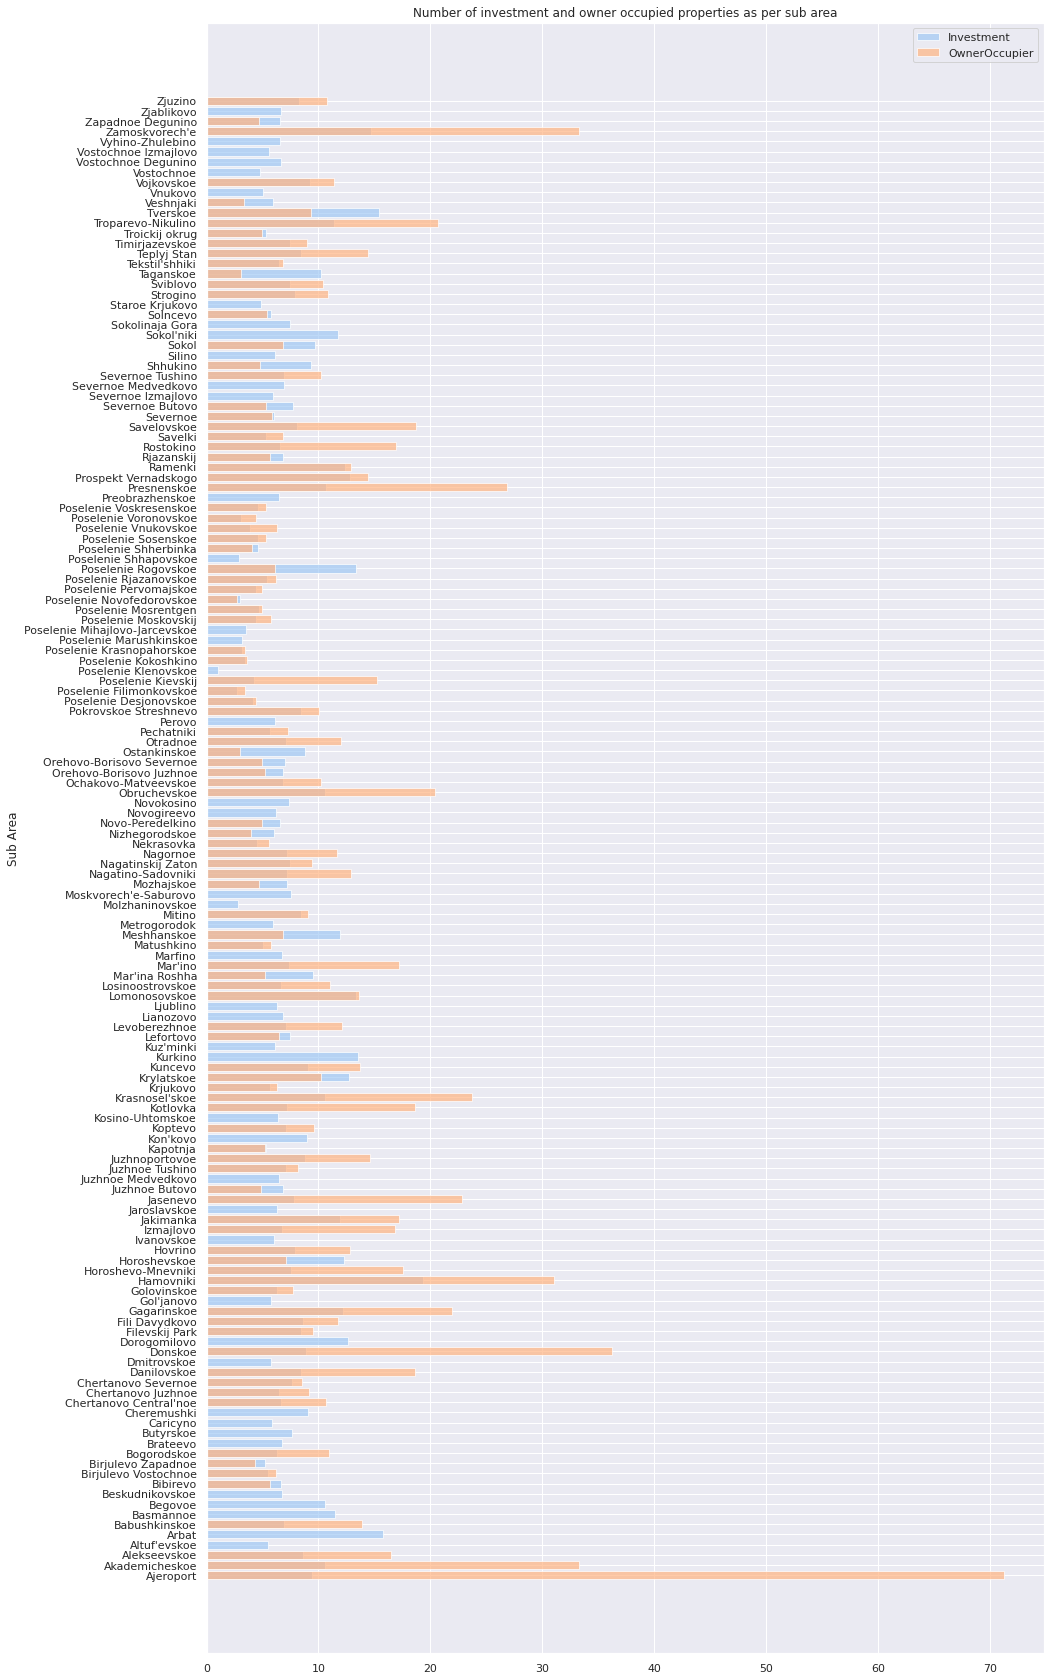

In [ ]:
df_invest=df[df["product_type"]=="Investment"].groupby("sub_area")['price_doc'].mean()
df_owner=df[df["product_type"]=="OwnerOccupier"].groupby("sub_area")['price_doc'].mean()

fig, ax = plt.subplots(figsize=(15,30))
p1 = plt.barh(df_invest.index.values,df_invest.values,alpha=0.7)
p2 = plt.barh(df_owner.index.values,df_owner.values,alpha=0.7)
plt.ylabel('Sub Area')
plt.title('Number of investment and owner occupied properties as per sub area')
plt.legend((p1[0], p2[0]), ('Investment', 'OwnerOccupier'))

plt.show()

In [ ]:
# https://ru.wikipedia.org/wiki/Районы_и_поселения_Москвы
df['sub_area'].nunique()

146

### raion_features

In [ ]:
raion_features= df.columns.difference(flat_features+target+['year']+['month_year']+['suspicious_offer'])

In [ ]:
def filter_list(sub_str, full_list):
  return  [x for x in full_list if sub_str in x]

keys = [
    'build','cafe','market','office','school','sport','church',
    'metro','trc','railroad','green_part','prom_part','leisure','mosque']
    
raion_features_dict = {x:filter_list(x, raion_features) for x in keys}
raion_features_dict['all_m_f']= [x for x in raion_features if ('_all' in x)or ('male' in x)or('female' in x)]

In [ ]:
import itertools

raion_features_dict_all_cols = list(itertools.chain.from_iterable(list(raion_features_dict.values())))
raion_features_min= raion_features.difference(raion_features_dict_all_cols)

In [ ]:
def missing_sub_area(cols):
  temp=[]
  cnt=[]
  n_col=0
  for col in cols:
    temp=np.sum([(df[col].isnull().groupby(df['sub_area']).sum()).values.tolist(),temp],axis=0)
    if df[col].isnull().sum()!=0:
      n_col+=1 
  cnt=(df.groupby(df['sub_area']).count().max(axis=1)*n_col).values.tolist()
  area = df[col].isnull().groupby(df['sub_area']).sum().index.tolist()
  df_temp=pd.DataFrame({'sub_area': area, '%_missing': np.round(temp/cnt*100,1)})
  return df_temp[df_temp['%_missing']>0]

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def PCA_group_features(features_names,n_components=8):
  pca = PCA(n_components=n_components)
  for key, value in raion_features_dict.items():
    if features_names == value:
      s=key
  # s=re.search(r"\'(\w+)\'", str(f"{features_names}")).group(0)[1:-1]
  # f = lambda x: x
  # f = lambda x: StandardScaler().fit_transform(x)
  f = lambda x: np.log1p(x)/(np.log1p(x)+1)

  features_transformed = f(df[features_names].dropna())
  pca.fit(features_transformed)
  plt.plot(pca.explained_variance_ratio_.cumsum(), 'o-'); plt.show()

  pca_features = pca.transform(f(df[features_names].fillna(np.median(features_transformed))))
  pca_cols = [f'pca_{s}_{i}' for i in range(1,n_components+1)]
  pca_features = pd.DataFrame(pca_features, columns=pca_cols,index=df.index)
  df_tmp = pd.concat([pca_features,df[target]],axis=1)

  heatmap_data=df_tmp.corr()
  plot_corr_matrix(heatmap_data);
  return pca_features

#### build


*   **'build_count_1921-1945'** Доля зданий 1921-1945 годов постройки

*  **'build_count_1946-1970'** Доля зданий 1946-1970 годов постройки

*   **'build_count_1971-1995'** Доля зданий 1971-1995 годов постройки

*   **'build_count_after_1995'** Доля зданий после 1995 года
*   **'build_count_before_1920'** Доля зданий до 1920 года


*   **'build_count_block'** Доля блочных зданий

*   **'build_count_brick'** Доля кирпичных зданий

*   **'build_count_foam'** Доля пенобетонных зданий
*   **'build_count_frame'** Доля каркасных зданий


*   **'build_count_mix'** Доля смешаных зданий





*   **'build_count_monolith'** Доля монолитных зданий


*   **'build_count_panel'** Доля панельных зданий
*   **'build_count_slag'** Доля шлаковых зданий


*   **'build_count_wood'** Доля деревянных зданий


*   **'raion_build_count_with_builddate_info'** Количество зданий с информацией о годе постройки в районе


*   **'raion_build_count_with_material_info'** Количество зданий с информацией о материалах в районе



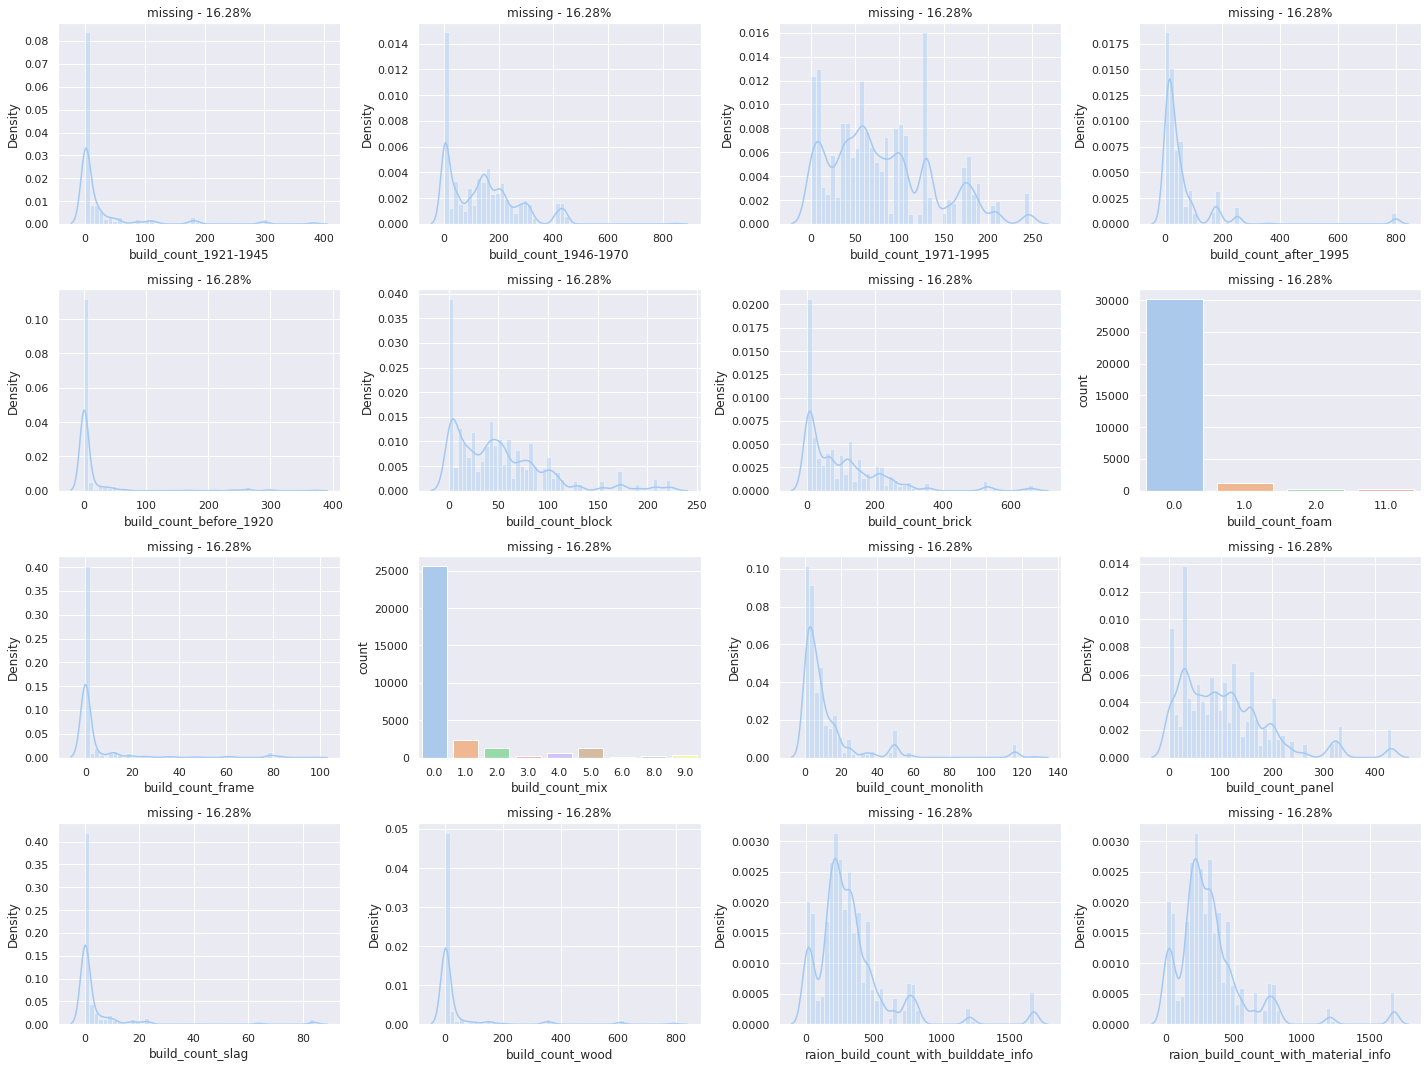

In [ ]:
cols_view(raion_features_dict['build'])

In [ ]:
missing_sub_area(raion_features_dict['build'])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


sub_area  %_missing
86           Poselenie Desjonovskoe       92.6
87         Poselenie Filimonkovskoe       87.6
88               Poselenie Kievskij      100.0
89             Poselenie Klenovskoe      100.0
91        Poselenie Krasnopahorskoe       90.3
93   Poselenie Mihajlovo-Jarcevskoe      100.0
95             Poselenie Mosrentgen      100.0
96        Poselenie Novofedorovskoe       96.8
98           Poselenie Rjazanovskoe      100.0
99              Poselenie Rogovskoe       89.2
100           Poselenie Shhapovskoe      100.0
102             Poselenie Sosenskoe       96.4
103            Poselenie Vnukovskoe       97.3
104           Poselenie Voronovskoe      100.0
105         Poselenie Voskresenskoe       95.7

<img src= https://s00.yaplakal.com/pics/pics_original/3/5/1/13521153.jpg>

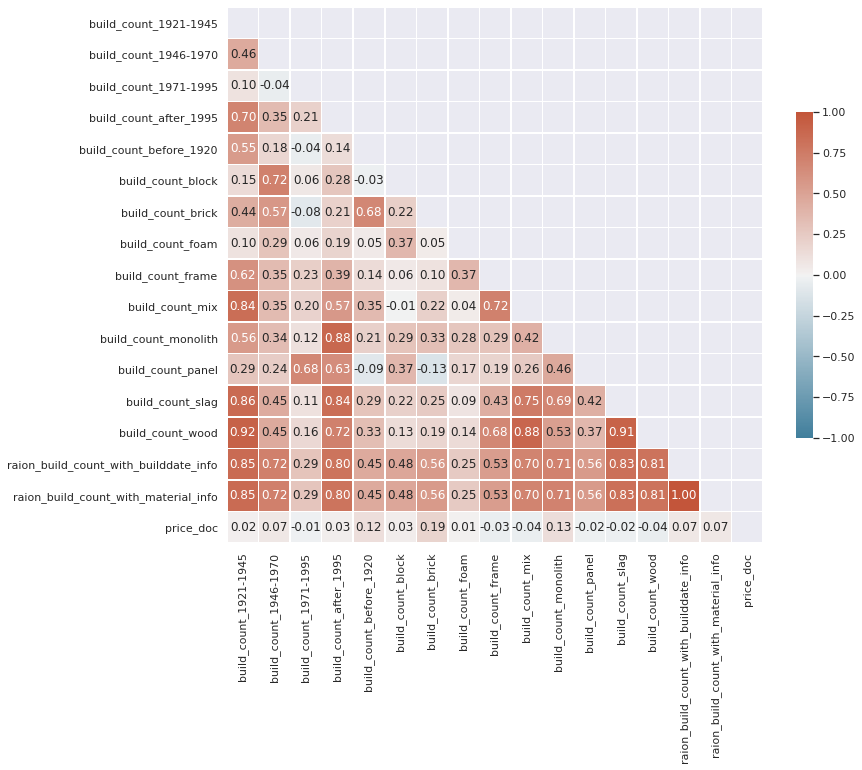

In [ ]:
heatmap_data=df[raion_features_dict['build']+target].corr()
plot_corr_matrix(heatmap_data,figsize=(12,12))

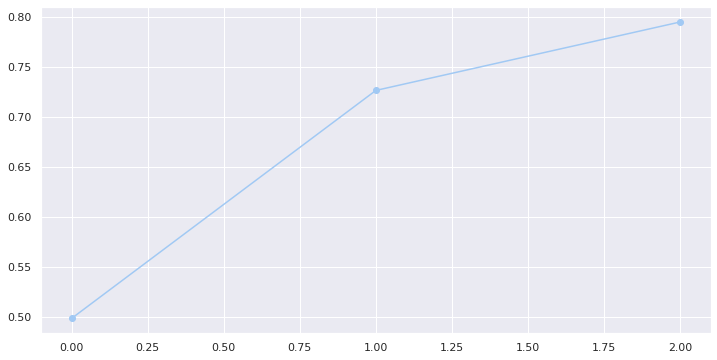

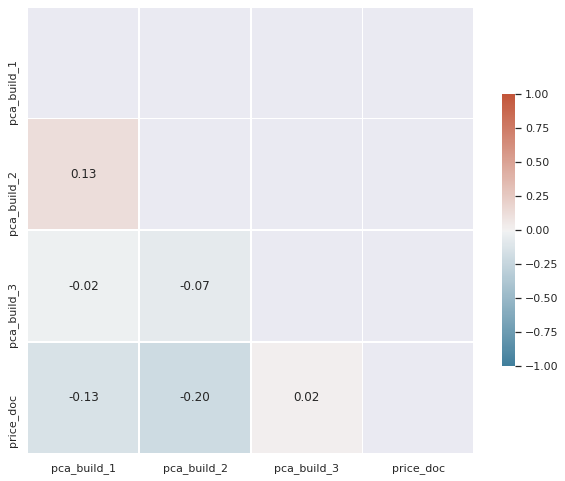

In [ ]:
 df_pca=PCA_group_features(raion_features_dict['build'],n_components=3)

In [ ]:
# df.drop(raion_features_dict['build'],axis=1,inplace=True)
# df=pd.concat([df,df_pca],axis=1)

#### cafe


*   **'cafe_avg_price_Х'** Средний счет кафе и ресторанов в зоне Х метров

*   **'cafe_count_Х'** Количество кафе или ресторанов в зоне Х метров


*   **'cafe_count_X_na_price'** Кафе и рестораны в зоне X метров счет не доступен 

*   **'cafe_count_X_price_Y'** Счет кафе и ресторанов в зоне X метров, в среднем Y 

*   **'cafe_count_X_price_high'** Счет кафе и ресторанов в зоне X метров, в среднем более 4000Р

*   **'cafe_sum_X_max_price_avg'** Минимальный средний счет кафе и ресторанов в зоне X метров
 
*   **'cafe_sum_X_min_price_avg'** Максимальный средний счет кафе и ресторанов в зоне X метров




In [ ]:
for col in raion_features_dict['cafe']:
    pct_missing = np.mean(df[col].isnull())
    if pct_missing != 0:
        print('{} - {}%'.format(col, round(pct_missing*100)))

cafe_avg_price_1000 - 20%
cafe_avg_price_1500 - 13%
cafe_avg_price_2000 - 6%
cafe_avg_price_3000 - 3%
cafe_avg_price_500 - 43%
cafe_avg_price_5000 - 1%
cafe_sum_1000_max_price_avg - 20%
cafe_sum_1000_min_price_avg - 20%
cafe_sum_1500_max_price_avg - 13%
cafe_sum_1500_min_price_avg - 13%
cafe_sum_2000_max_price_avg - 6%
cafe_sum_2000_min_price_avg - 6%
cafe_sum_3000_max_price_avg - 3%
cafe_sum_3000_min_price_avg - 3%
cafe_sum_5000_max_price_avg - 1%
cafe_sum_5000_min_price_avg - 1%
cafe_sum_500_max_price_avg - 43%
cafe_sum_500_min_price_avg - 43%


In [ ]:
missing_sub_area(raion_features_dict['cafe'])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


sub_area  %_missing
0               Ajeroport        1.0
1          Akademicheskoe        0.1
2            Alekseevskoe        0.6
5           Babushkinskoe        1.2
8         Beskudnikovskoe        2.0
..                    ...        ...
140  Vostochnoe Izmajlovo        5.3
141      Vyhino-Zhulebino        8.9
143     Zapadnoe Degunino       21.9
144            Zjablikovo        9.1
145               Zjuzino        1.5

[129 rows x 2 columns]

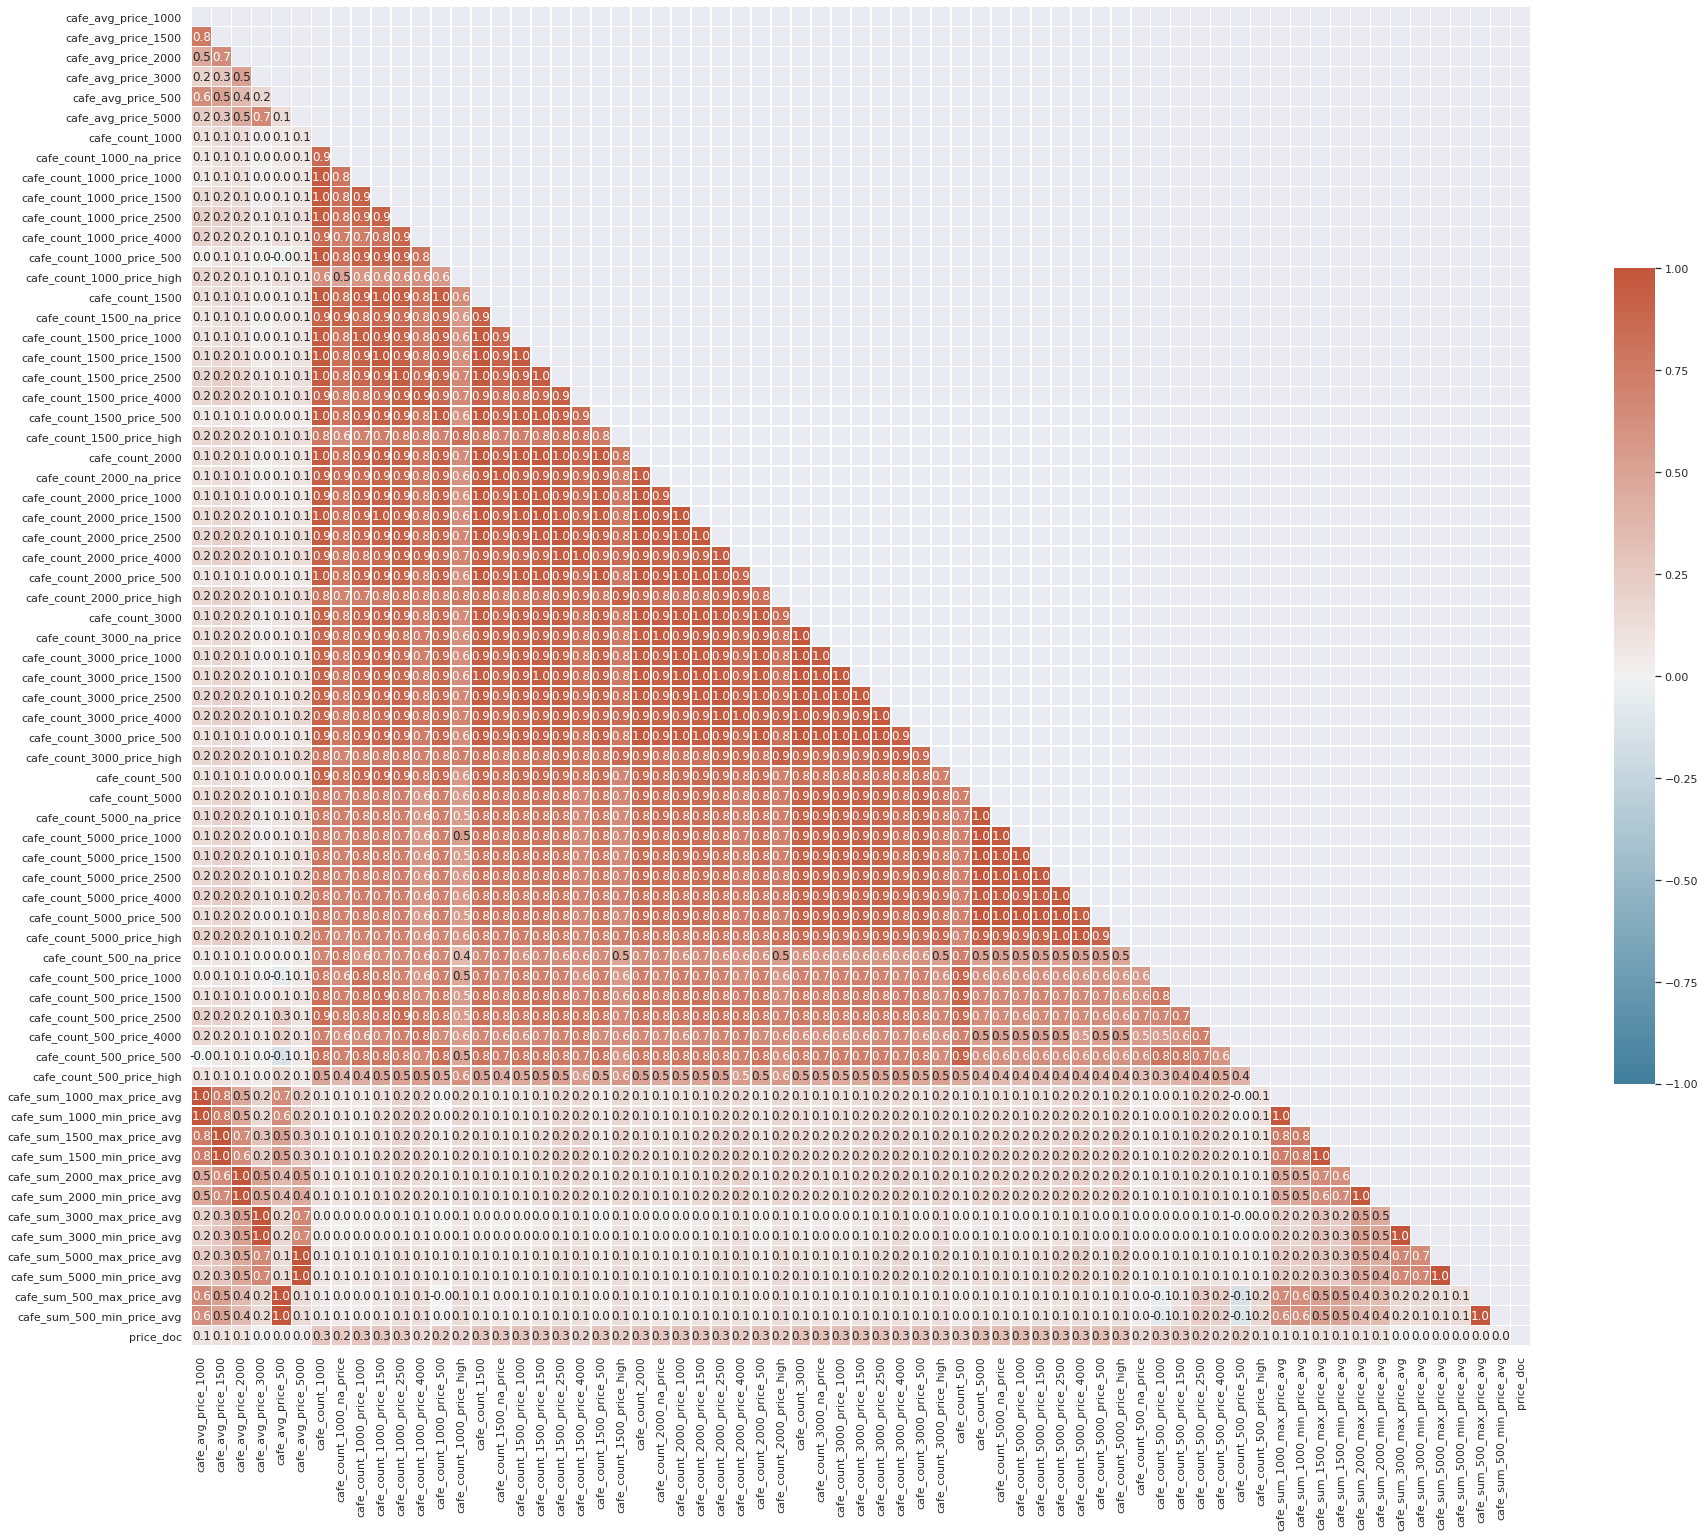

In [ ]:
heatmap_data=df[raion_features_dict['cafe']+target].corr()
plot_corr_matrix(heatmap_data,figsize=(30,30),fmt='.1f')

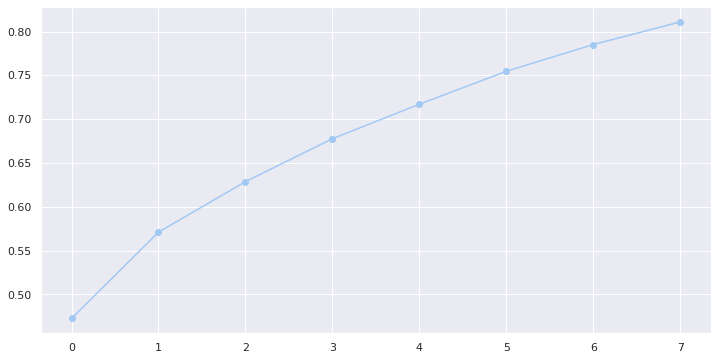

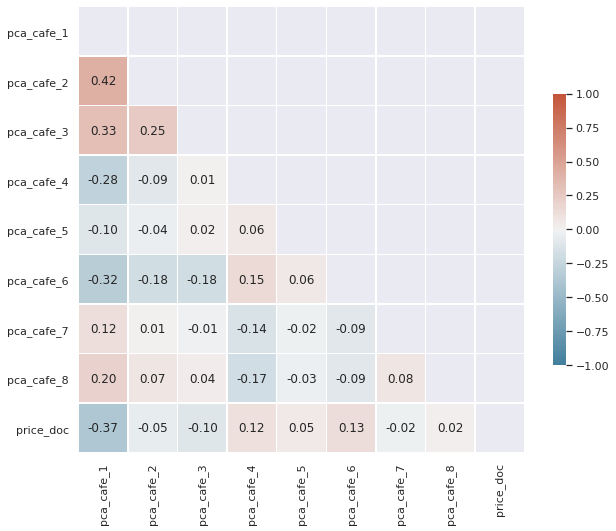

In [ ]:
df_pca=PCA_group_features(raion_features_dict['cafe'],n_components=8)

In [ ]:
df.drop(raion_features_dict['cafe'],axis=1,inplace=True)
df=pd.concat([df,df_pca],axis=1)

#### school
*   **'children_preschool'** Численность населения дошкольного возраста

*    **'children_school'** Численность населения школьного возраста

*   **'preschool_education_centers_raion'** Количество дошкольных учреждений

*   **'preschool_km'** Расстояние до дошкольных образовательных организаций

*   **'school_km'** Расстояние до средней школы
*   **'preschool_quota'** Количество мест в дошкольных организациях


*   **'school_quota'** Количество мест в средней школе в районе


*   **'school_education_centers_raion'** Количество высших учебных заведений


*   **'school_education_centers_top_20_raion'** Количество вузов из топ-20 лучших Москвы

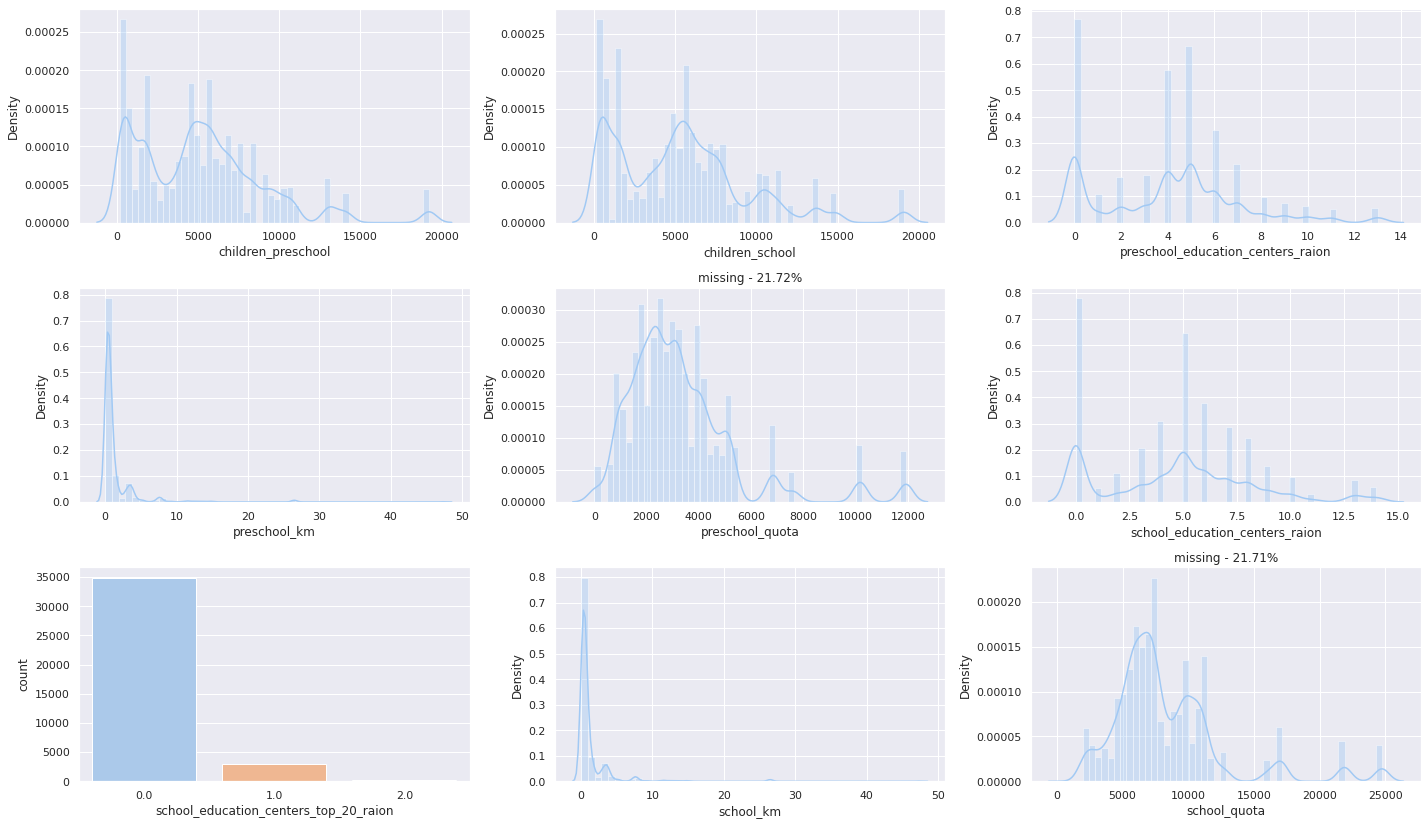

In [ ]:
cols_view(raion_features_dict['school'])

In [ ]:
missing_sub_area(raion_features_dict['school'])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


sub_area  %_missing
66                  Molzhaninovskoe       50.0
86           Poselenie Desjonovskoe       92.6
87         Poselenie Filimonkovskoe       87.6
88               Poselenie Kievskij      100.0
89             Poselenie Klenovskoe      100.0
90             Poselenie Kokoshkino      100.0
91        Poselenie Krasnopahorskoe       90.3
92          Poselenie Marushkinskoe      100.0
93   Poselenie Mihajlovo-Jarcevskoe      100.0
94             Poselenie Moskovskij       95.5
95             Poselenie Mosrentgen      100.0
96        Poselenie Novofedorovskoe       96.8
97           Poselenie Pervomajskoe      100.0
98           Poselenie Rjazanovskoe      100.0
99              Poselenie Rogovskoe       89.2
100           Poselenie Shhapovskoe      100.0
101            Poselenie Shherbinka       93.1
102             Poselenie Sosenskoe       96.4
103            Poselenie Vnukovskoe       97.3
104           Poselenie Voronovskoe      100.0
105         Poselenie Voskresenskoe       95.7
132                  Troickij okrug       99.4

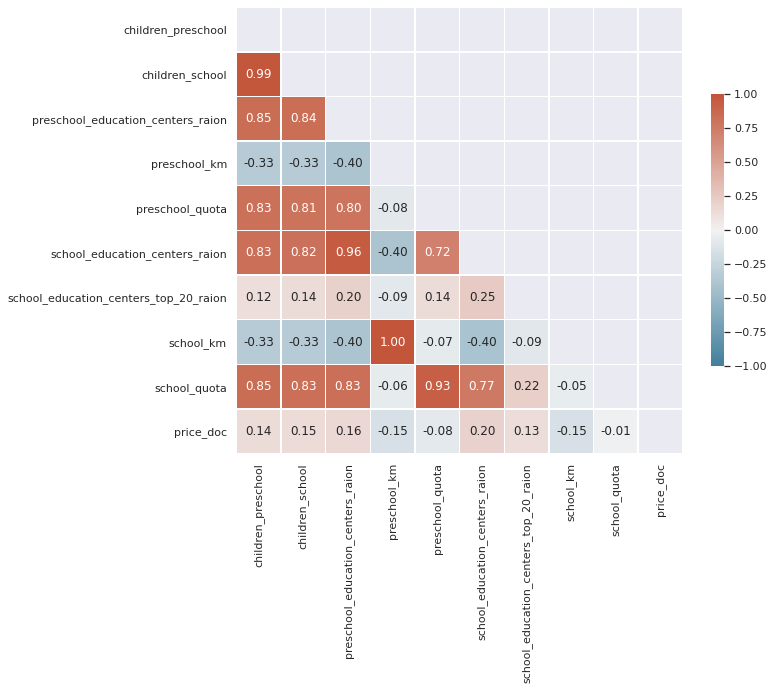

In [ ]:
heatmap_data=df[raion_features_dict['school']+target].corr()
plot_corr_matrix(heatmap_data,figsize=(10,10),fmt='.2f')

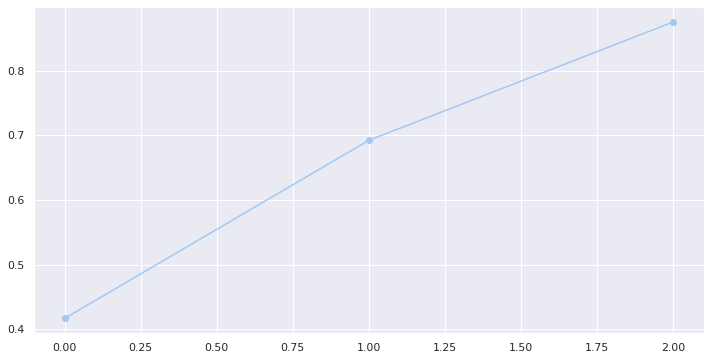

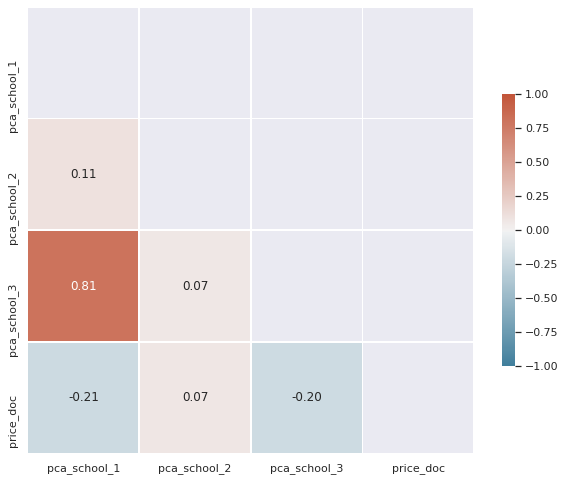

In [ ]:
df_pca=PCA_group_features(raion_features_dict['school'],n_components=3)

In [ ]:
# df.drop(raion_features_dict['school'],axis=1,inplace=True)
# df=pd.concat([df,df_pca],axis=1)

#### market
*   **'big_market_km'** Расстояние до продуктовых / оптовых рынков

*   **'big_market_raion'** Наличие крупных продуктовых / оптовых рынков
*   **'market_count_Х'** Количество рынков в зоне Х метров


*   **'market_shop_km'** Расстояние до рынков и универмагов


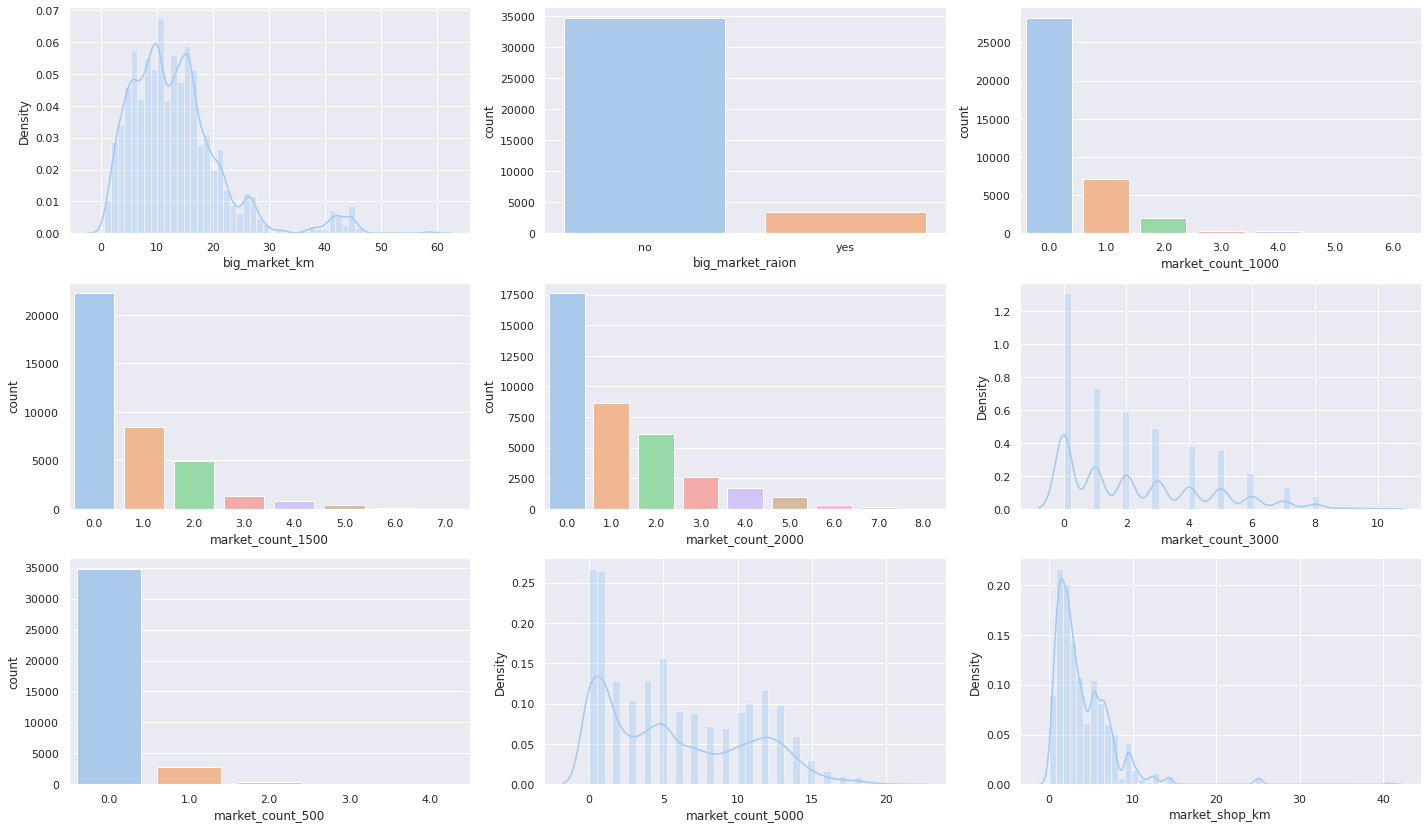

In [ ]:
cols_view(raion_features_dict['market'])

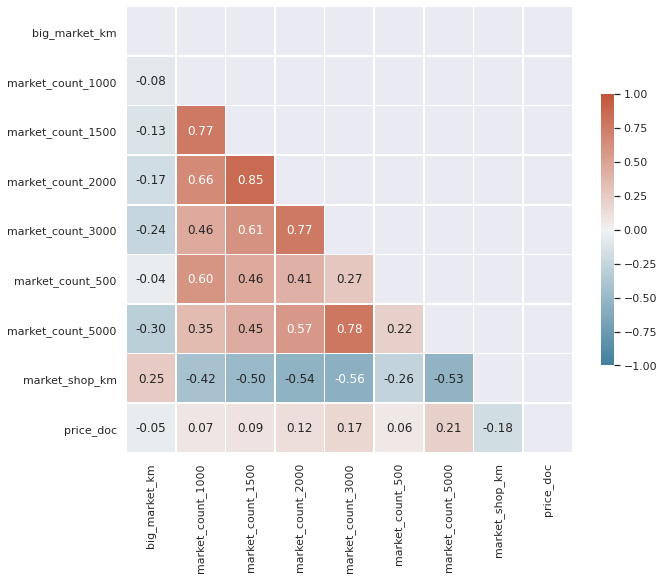

In [ ]:
heatmap_data=df[raion_features_dict['market']+target].corr()
plot_corr_matrix(heatmap_data,figsize=(10,10),fmt='.2f')

#### office
*   **'office_count_X'** Количество офисных помещений в зоне X метров
*   **'office_km'** Расстояние до бизнес-центров/ офисов
*   **'office_raion'** Количество бизнес-центров/ офисов в районе
*   **'office_sqm_X'** Площадь офисных помещений в зоне X метров



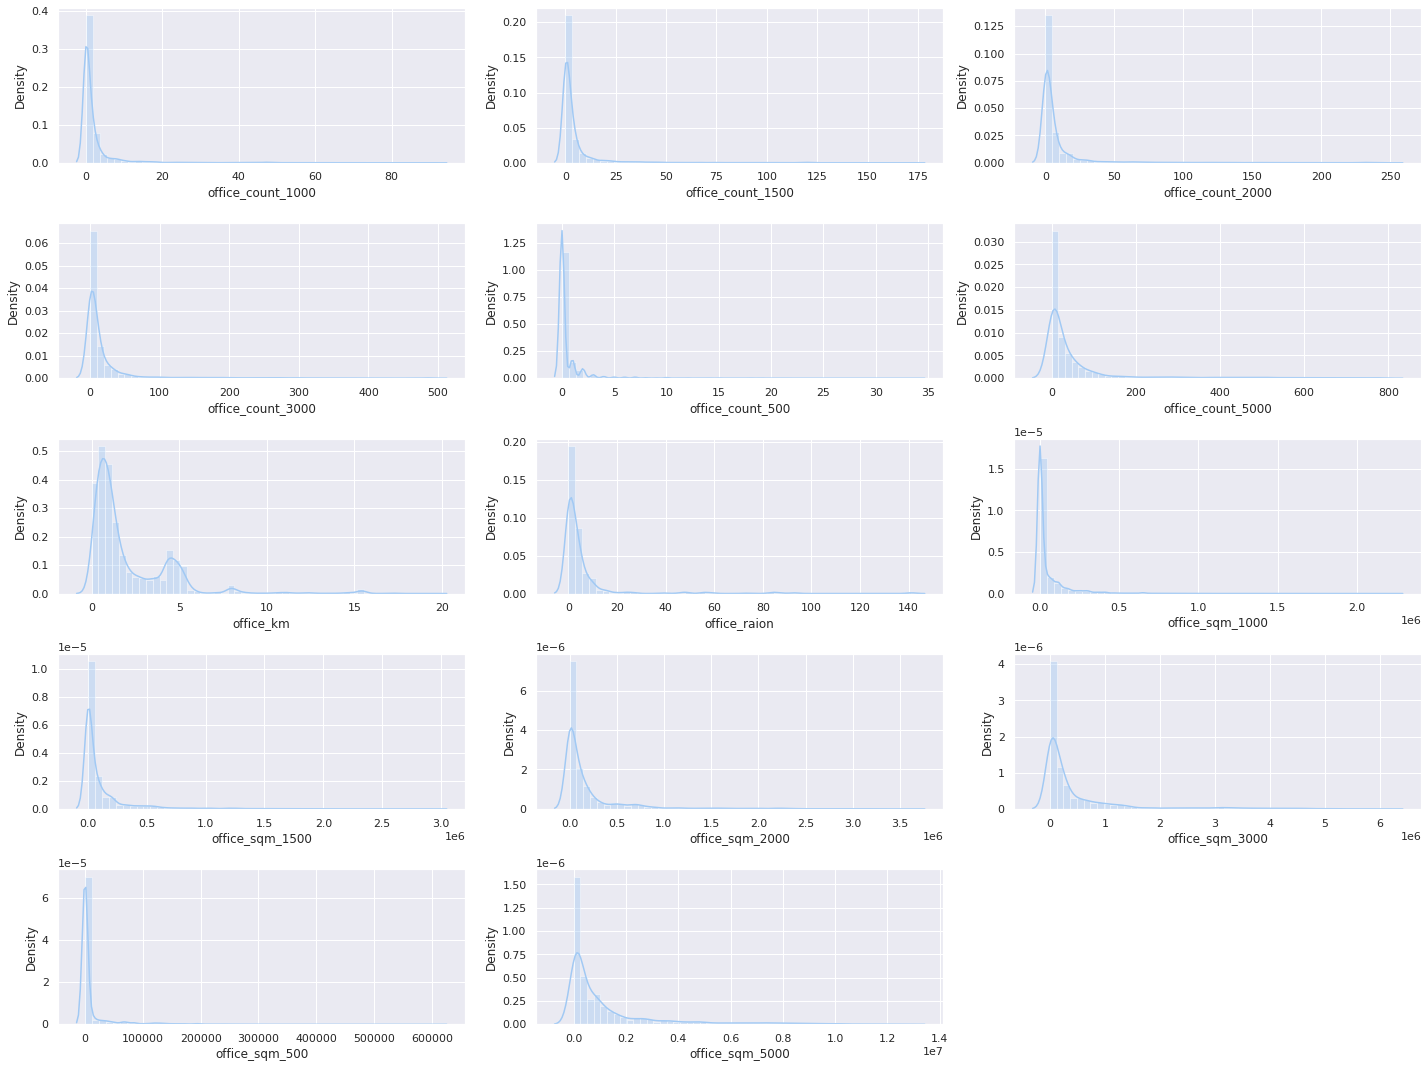

In [ ]:
cols_view(raion_features_dict['office'])

Сильная корреляция между собой

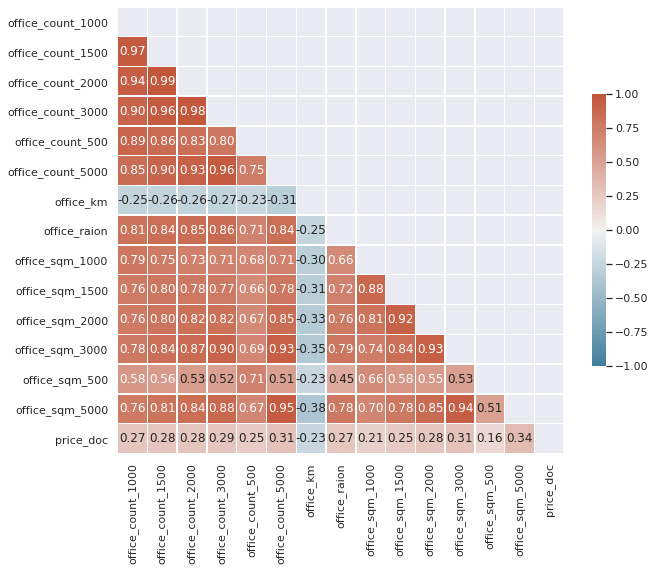

In [ ]:
heatmap_data=df[raion_features_dict['office']+target].corr()
plot_corr_matrix(heatmap_data,figsize=(10,10),fmt='.2f')

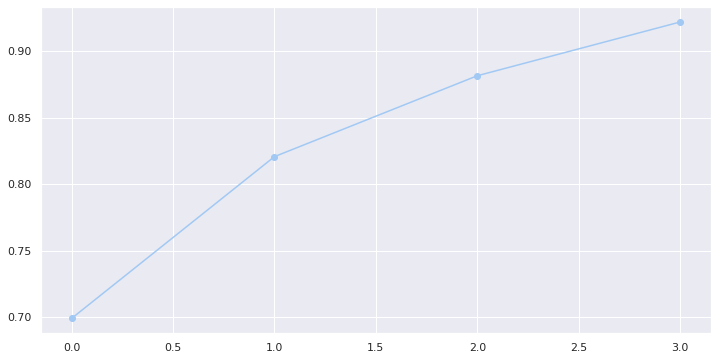

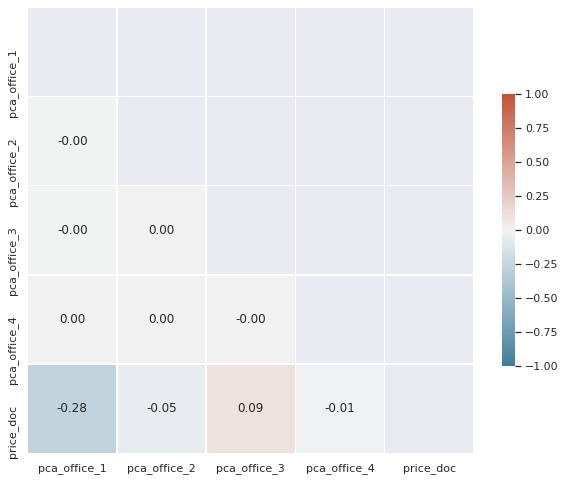

In [ ]:
df_pca=PCA_group_features(raion_features_dict['office'],n_components=4)

In [ ]:
df.drop(raion_features_dict['office'],axis=1,inplace=True)
df=pd.concat([df,df_pca],axis=1)

#### sport_transport
*   **'public_transport_station_km'** Расстояние до станции общественного транспорта (пешком)
*   **'public_transport_station_min_walk'** Время до остановки общественного транспорта (пешком)
*   **'sport_count_X'** Количество спортивных сооружений в X-метровой зоне

*   **'sport_objects_raion'** Количество спортивных сооружений в районе



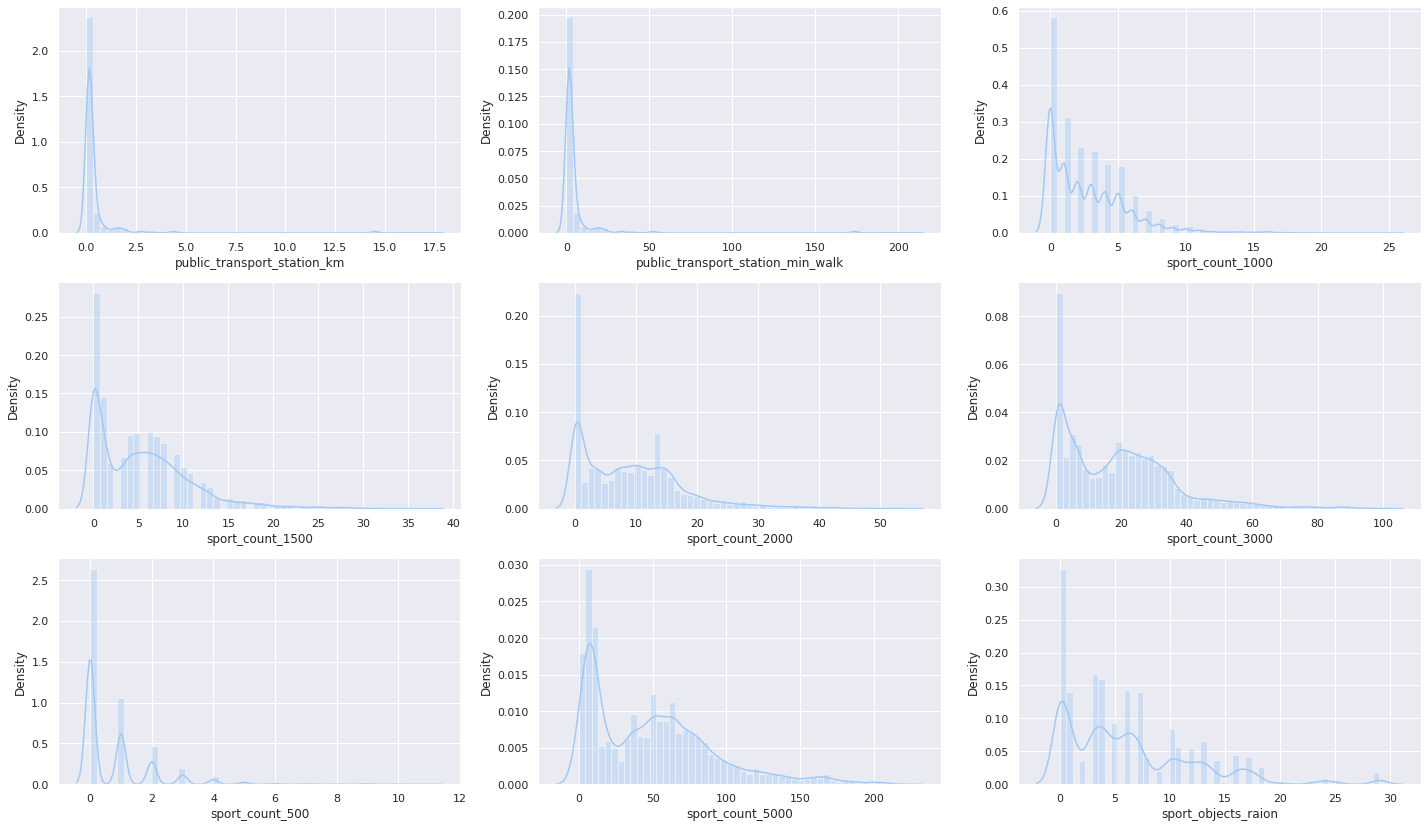

In [ ]:
cols_view(raion_features_dict['sport'])

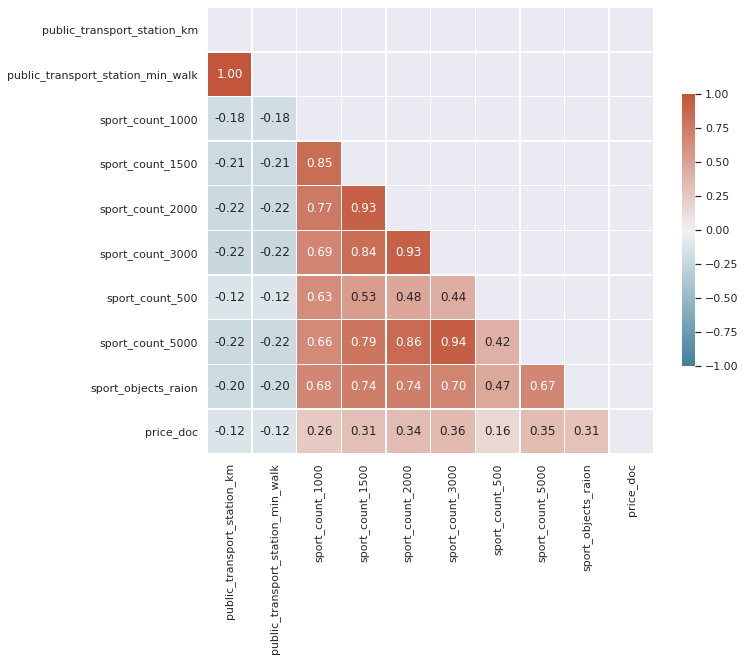

In [ ]:
heatmap_data=df[raion_features_dict['sport']+target].corr()
plot_corr_matrix(heatmap_data,figsize=(10,10),fmt='.2f')

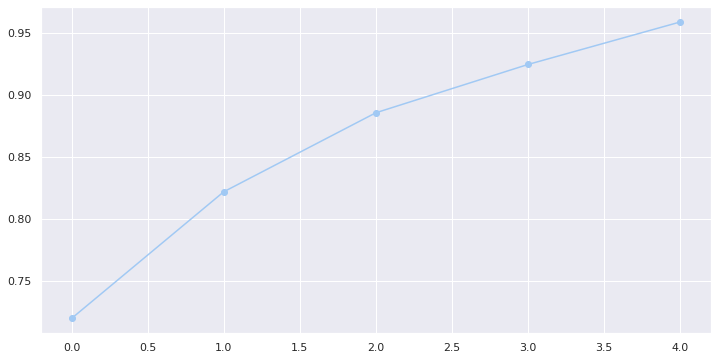

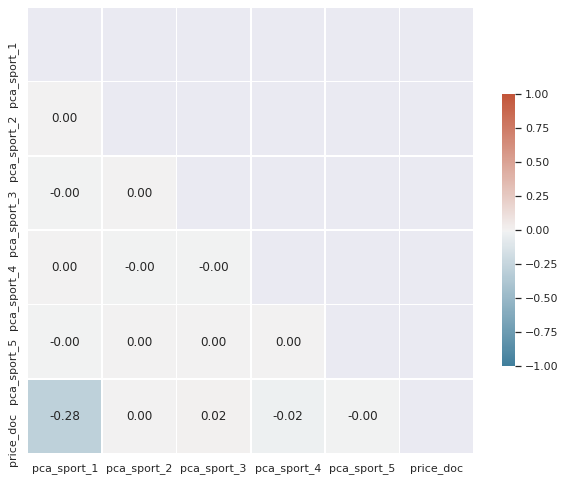

In [ ]:
df_pca=PCA_group_features(raion_features_dict['sport'],n_components=5)

In [ ]:
# df.drop(raion_features_dict['sport'],axis=1,inplace=True)
# df=pd.concat([df,df_pca],axis=1)

#### church
*   **'big_church_count_Х'** Количество больших церквей в Х-метровой зоне
*   **'big_church_km'** Расстояние до большой церкви
*   **'church_count_X'** Количество храмов в X-метровой зоне
*   **'church_synagogue_km'** Расстояние до христианских церквей и синагог



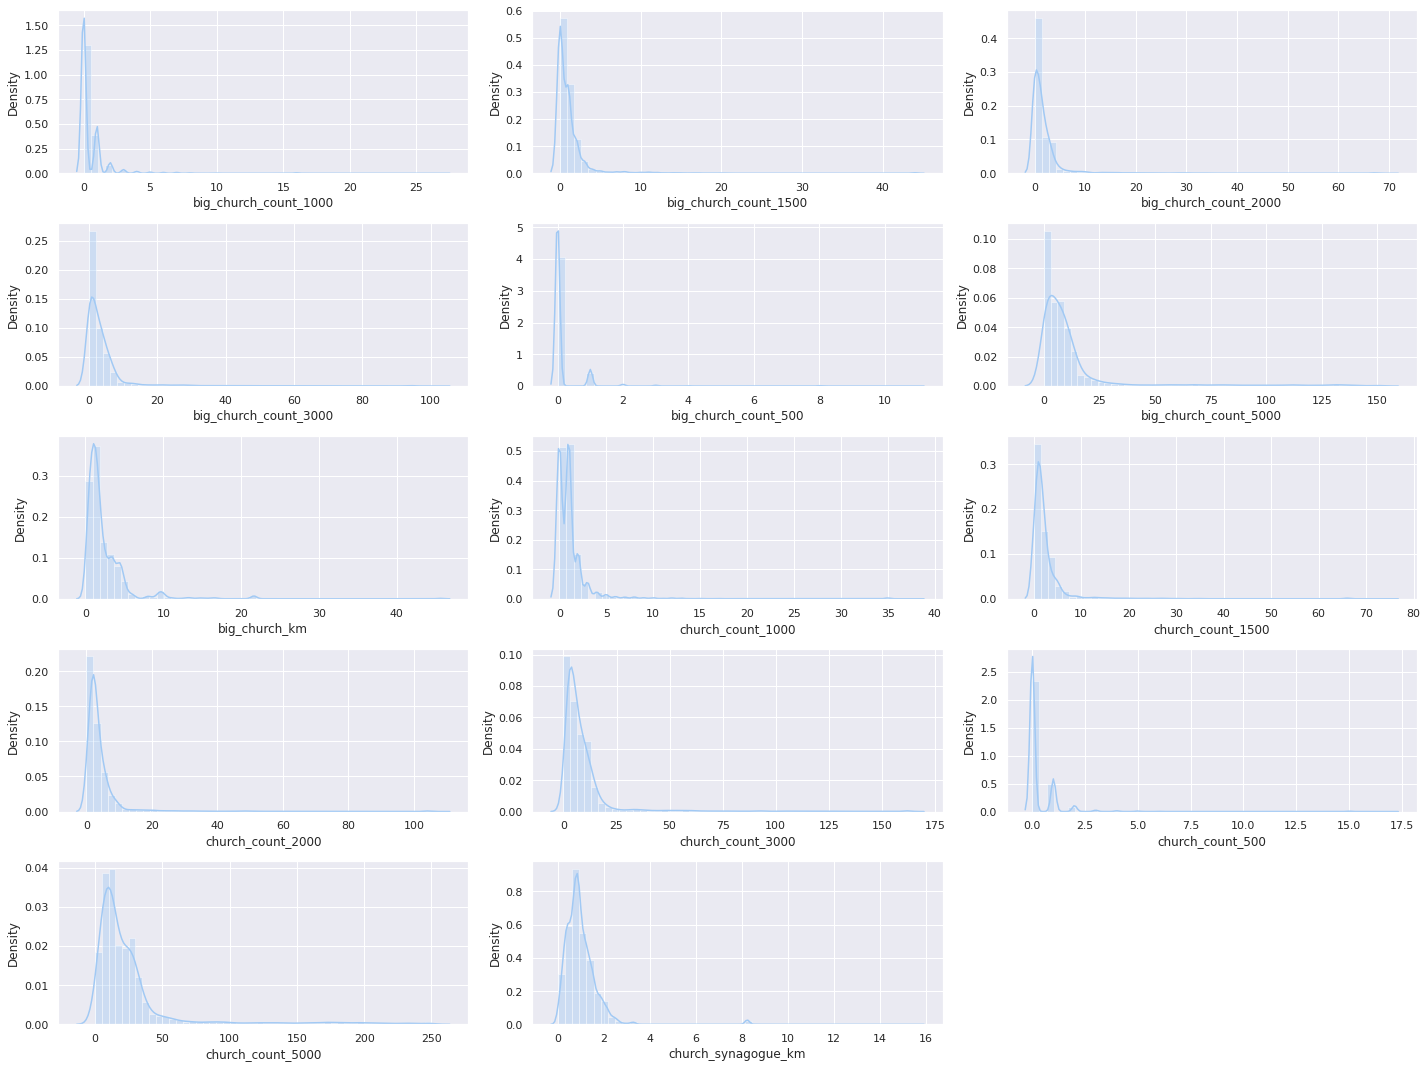

In [ ]:
cols_view(raion_features_dict['church'])

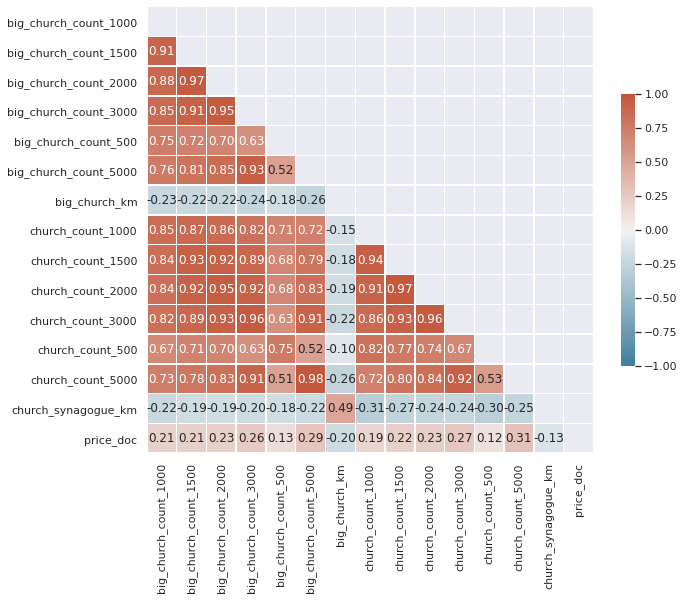

In [ ]:
heatmap_data=df[raion_features_dict['church']+target].corr()
plot_corr_matrix(heatmap_data,figsize=(10,10),fmt='.2f')

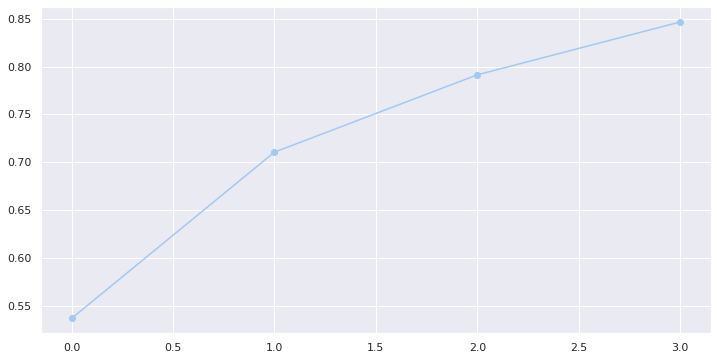

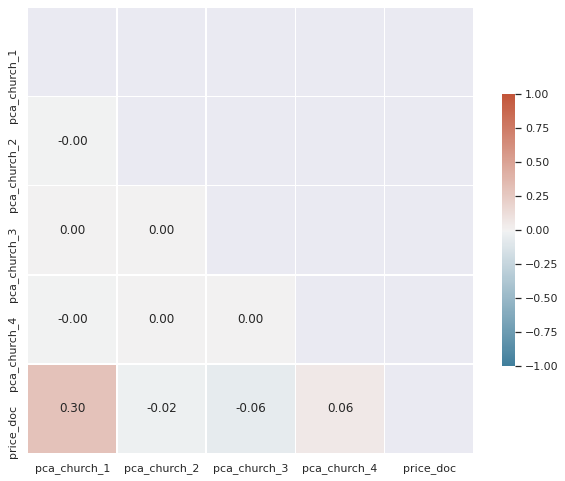

In [ ]:
df_pca=PCA_group_features(raion_features_dict['church'],n_components=4)

In [ ]:
df.drop(raion_features_dict['church'],axis=1,inplace=True)
df=pd.concat([df,df_pca],axis=1)

#### metro
*   **'ID_metro'** ID станции метро
*  **'metro_km_avto'** Расстояние до метро на машине, км
*   **'metro_km_walk'** Расстояние до метро, км
*   **'metro_min_avto'** Время до метро на машине, мин.
*   **'metro_min_walk'** Время до метро пешком


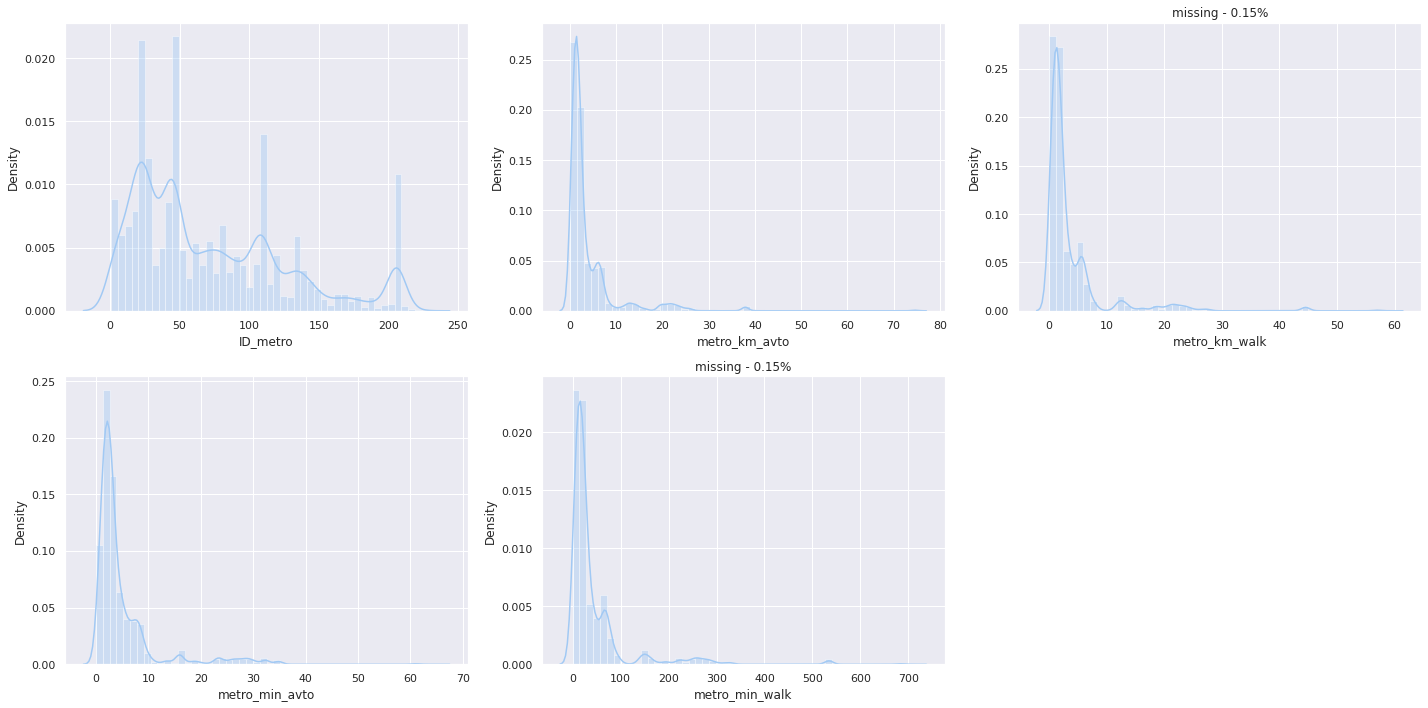

In [ ]:
cols_view(raion_features_dict['metro'],figsize=(20,10))

In [ ]:
missing_sub_area(raion_features_dict['metro'])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


sub_area  %_missing
7                 Begovoe        4.3
49             Krylatskoe       10.3
78   Ochakovo-Matveevskoe        0.6
103  Poselenie Vnukovskoe        0.2
131        Timirjazevskoe       15.5
137            Vojkovskoe        1.2

In [ ]:
for col in raion_features_dict['metro']:
  df[col] = df.groupby('sub_area')[col].apply(lambda x: x.fillna(x.mode().iloc[0]))

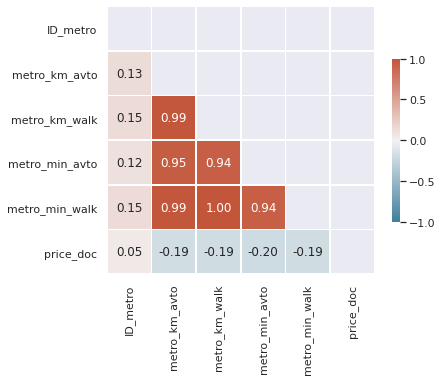

In [ ]:
heatmap_data=df[raion_features_dict['metro']+target].corr()
plot_corr_matrix(heatmap_data,figsize=(6,6),fmt='.2f')

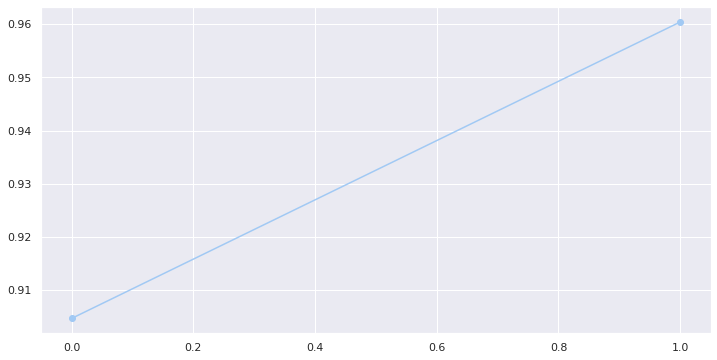

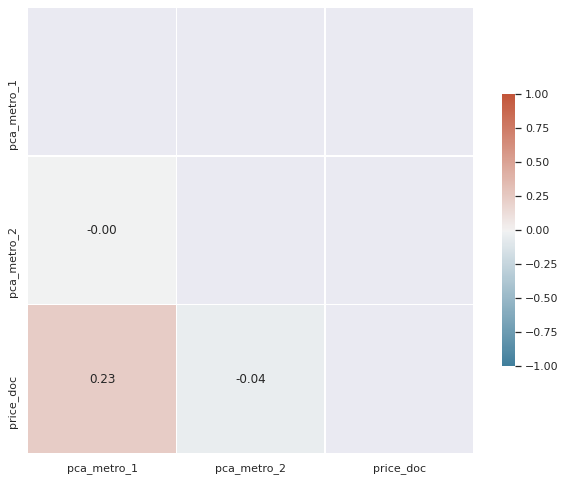

In [ ]:
df_pca=PCA_group_features(raion_features_dict['metro'],n_components=2)

In [ ]:
# df.drop(raion_features_dict['metro'],axis=1,inplace=True)
# df=pd.concat([df,df_pca],axis=1)

#### trc
*   **'trc_count_X'** Количество торговых центров в зоне X метров
*   **'trc_sqm_X'** Площадь торговых центров в зоне X метров



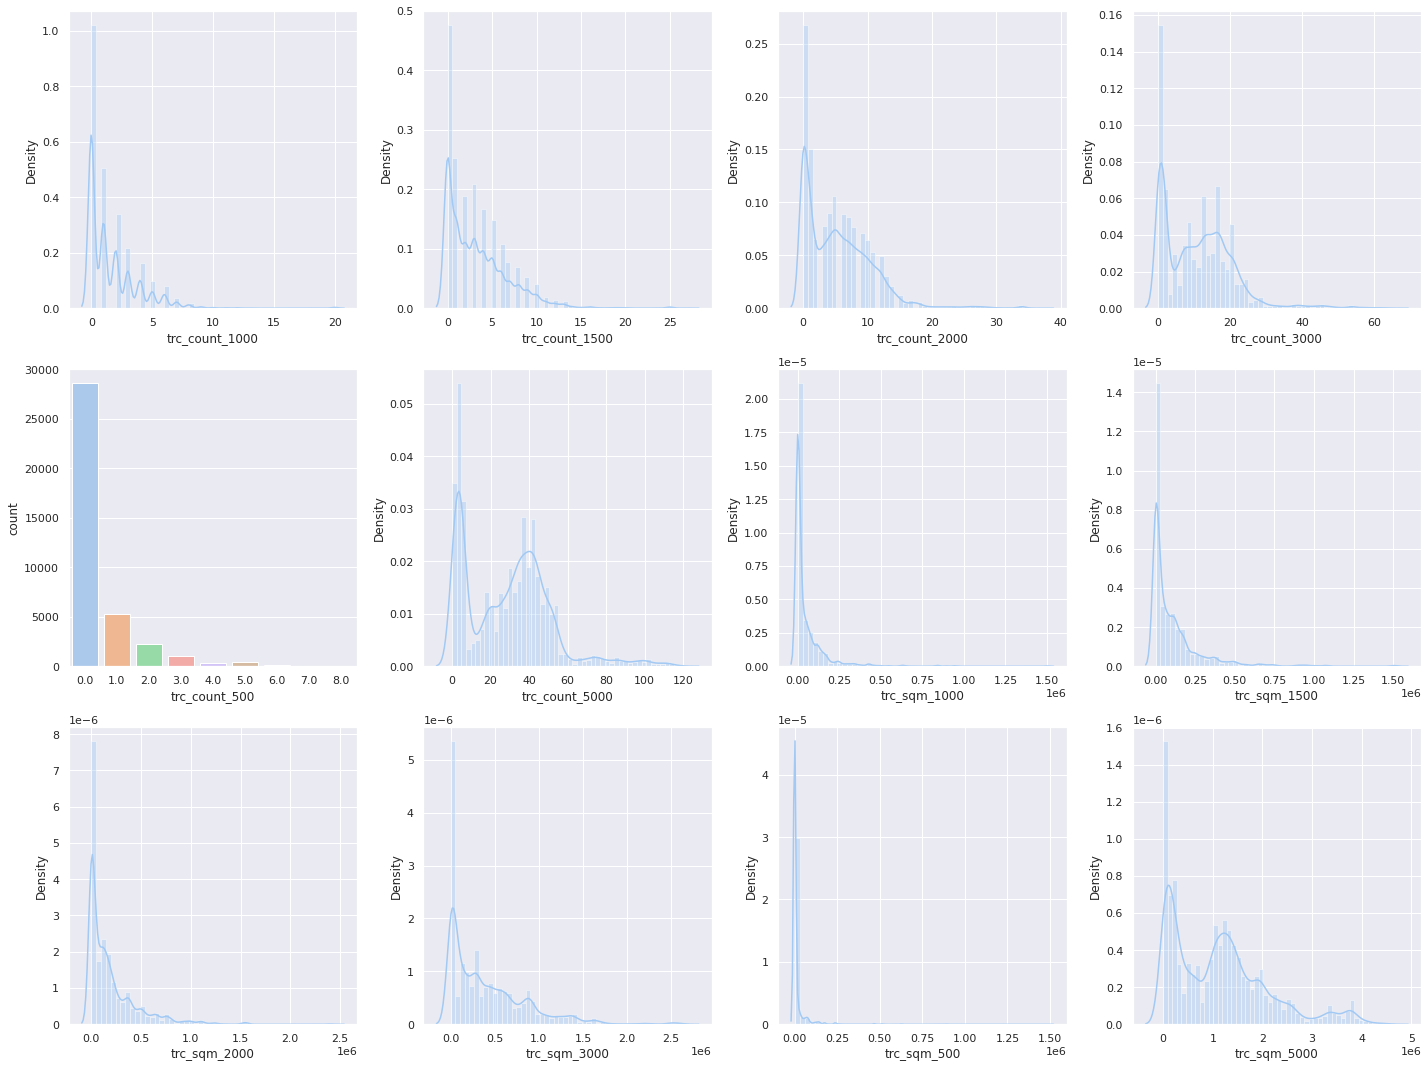

In [ ]:
cols_view(raion_features_dict['trc'])

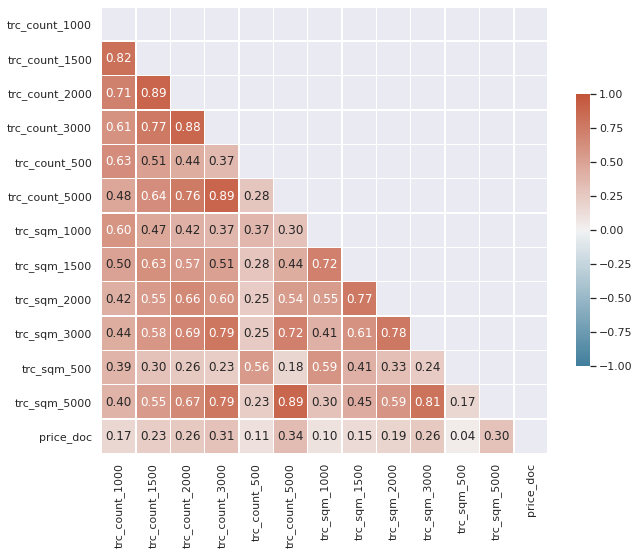

In [ ]:
heatmap_data=df[raion_features_dict['trc']+target].corr()
plot_corr_matrix(heatmap_data,fmt='.2f')

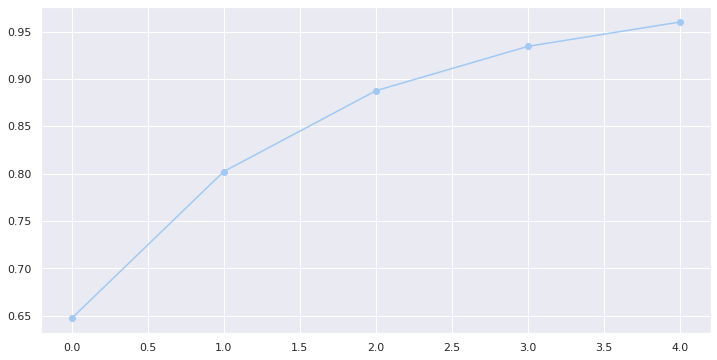

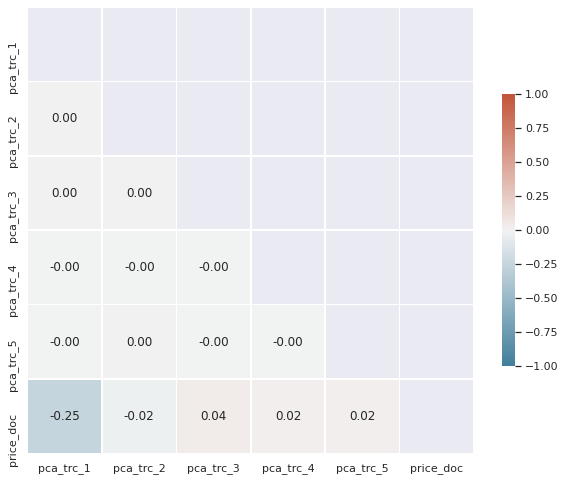

In [ ]:
df_pca=PCA_group_features(raion_features_dict['trc'],n_components=5)

In [ ]:
# df.drop(raion_features_dict['trc'],axis=1,inplace=True)
# df=pd.concat([df,df_pca],axis=1)

#### railroad
*  **'ID_railroad_station_avto'** Ближайшая железнодорожная станция (авто)
*   **'ID_railroad_station_walk'** Ближайшая железнодорожная станция (пешком)
*   **'ID_railroad_terminal'** Идентификатор ближайшего железнодорожного терминала
*   **'railroad_1line'** Первая линия до железной дороги (100 м)
*   **'railroad_km'** Расстояние до железной дороги / Московского Центрального кольца / открытых площадок метро
*   **'railroad_station_avto_km'** Расстояние до ж / д вокзала (авто)
*  **'railroad_station_avto_min'** Время до ж / д вокзала (авто)
*   **'railroad_station_walk_km'** Расстояние до ж / д вокзала (пешком)
*   **'railroad_station_walk_min'** Время до ж / д вокзала (пешком)
*  **'railroad_terminal_raion'** Наличие железнодорожного терминала в районе





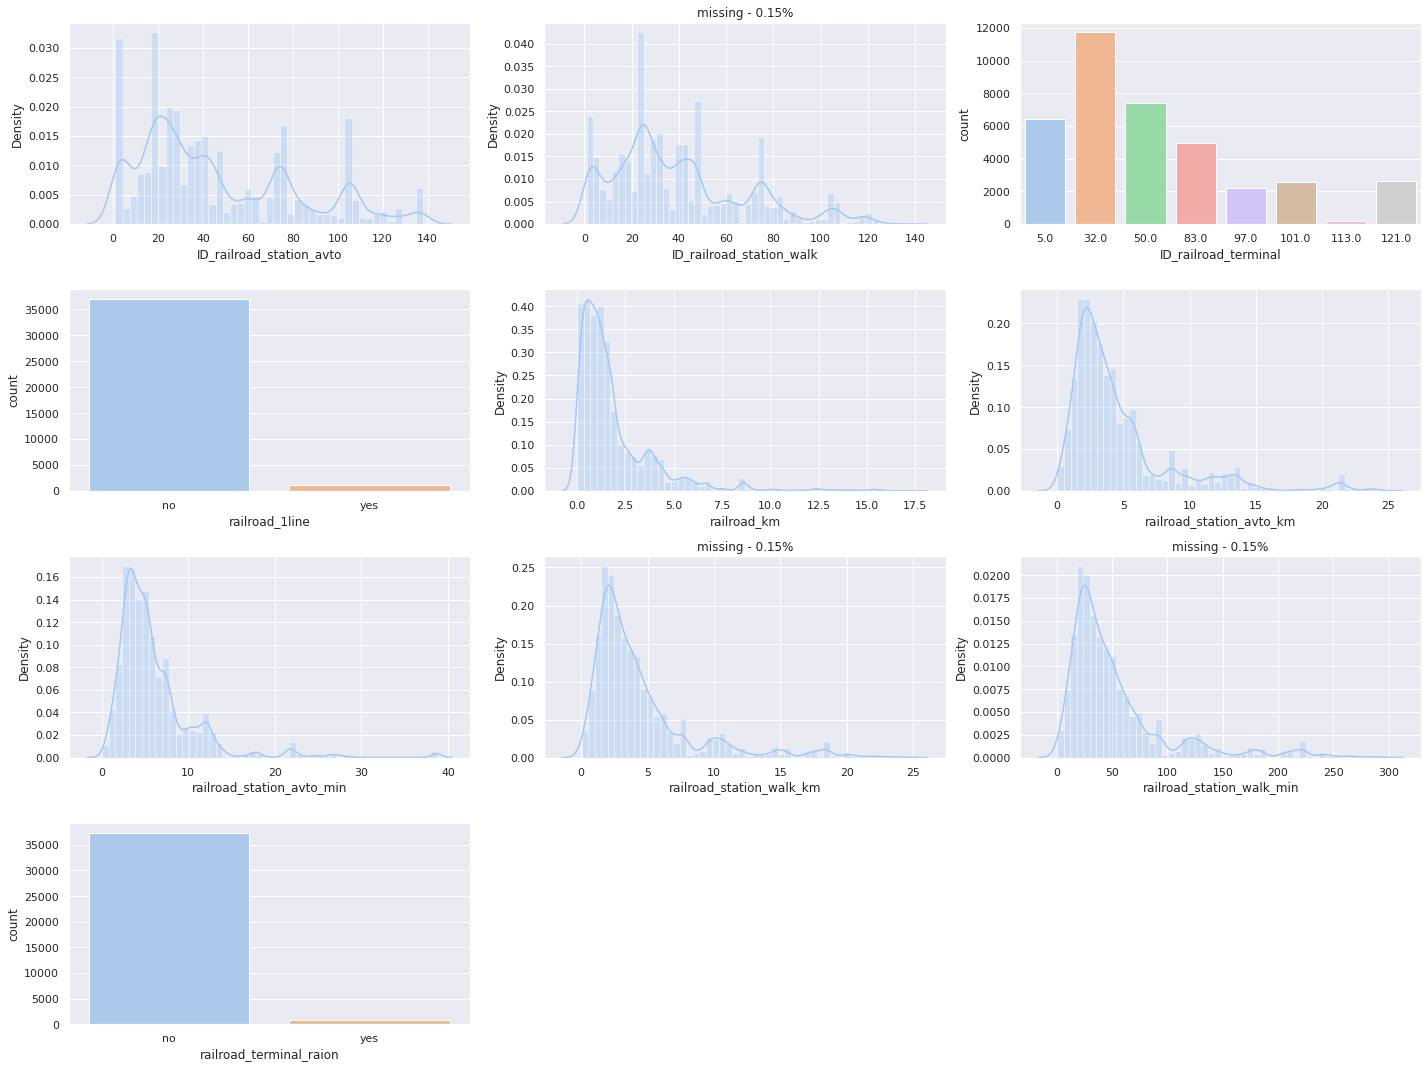

In [ ]:
cols_view(raion_features_dict['railroad'])

In [ ]:
missing_sub_area(raion_features_dict['railroad'])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


sub_area  %_missing
7                 Begovoe        4.3
49             Krylatskoe       10.3
78   Ochakovo-Matveevskoe        0.6
103  Poselenie Vnukovskoe        0.2
131        Timirjazevskoe       15.5
137            Vojkovskoe        1.2

In [ ]:
# for col in raion_features_dict['railroad']:
#   df[col] = df.groupby('sub_area')[col].apply(lambda x: x.fillna(x.mode().iloc[0]))

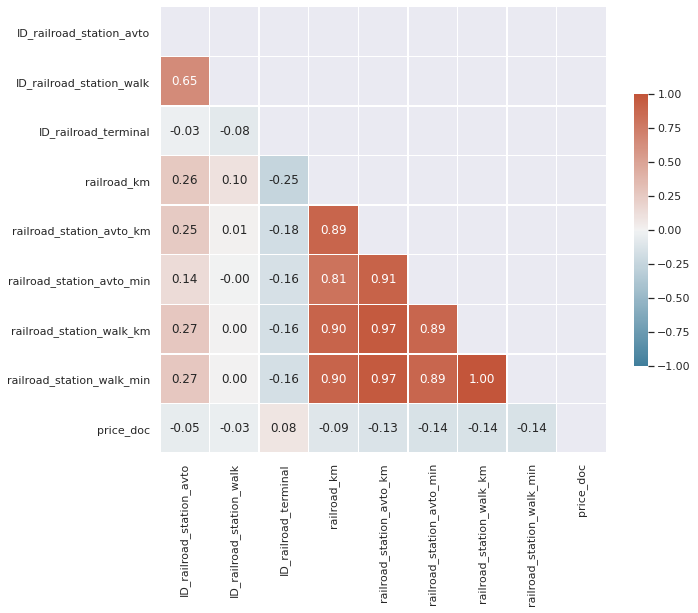

In [ ]:
heatmap_data=df[raion_features_dict['railroad']+target].corr()
plot_corr_matrix(heatmap_data,fmt='.2f')

#### green_part, prom_part
*   **'green_part_X'** Доля зеленых зон в X-метровой зоне
*   **'prom_part_X'** Доля промышленных зон в X-метровой зоне



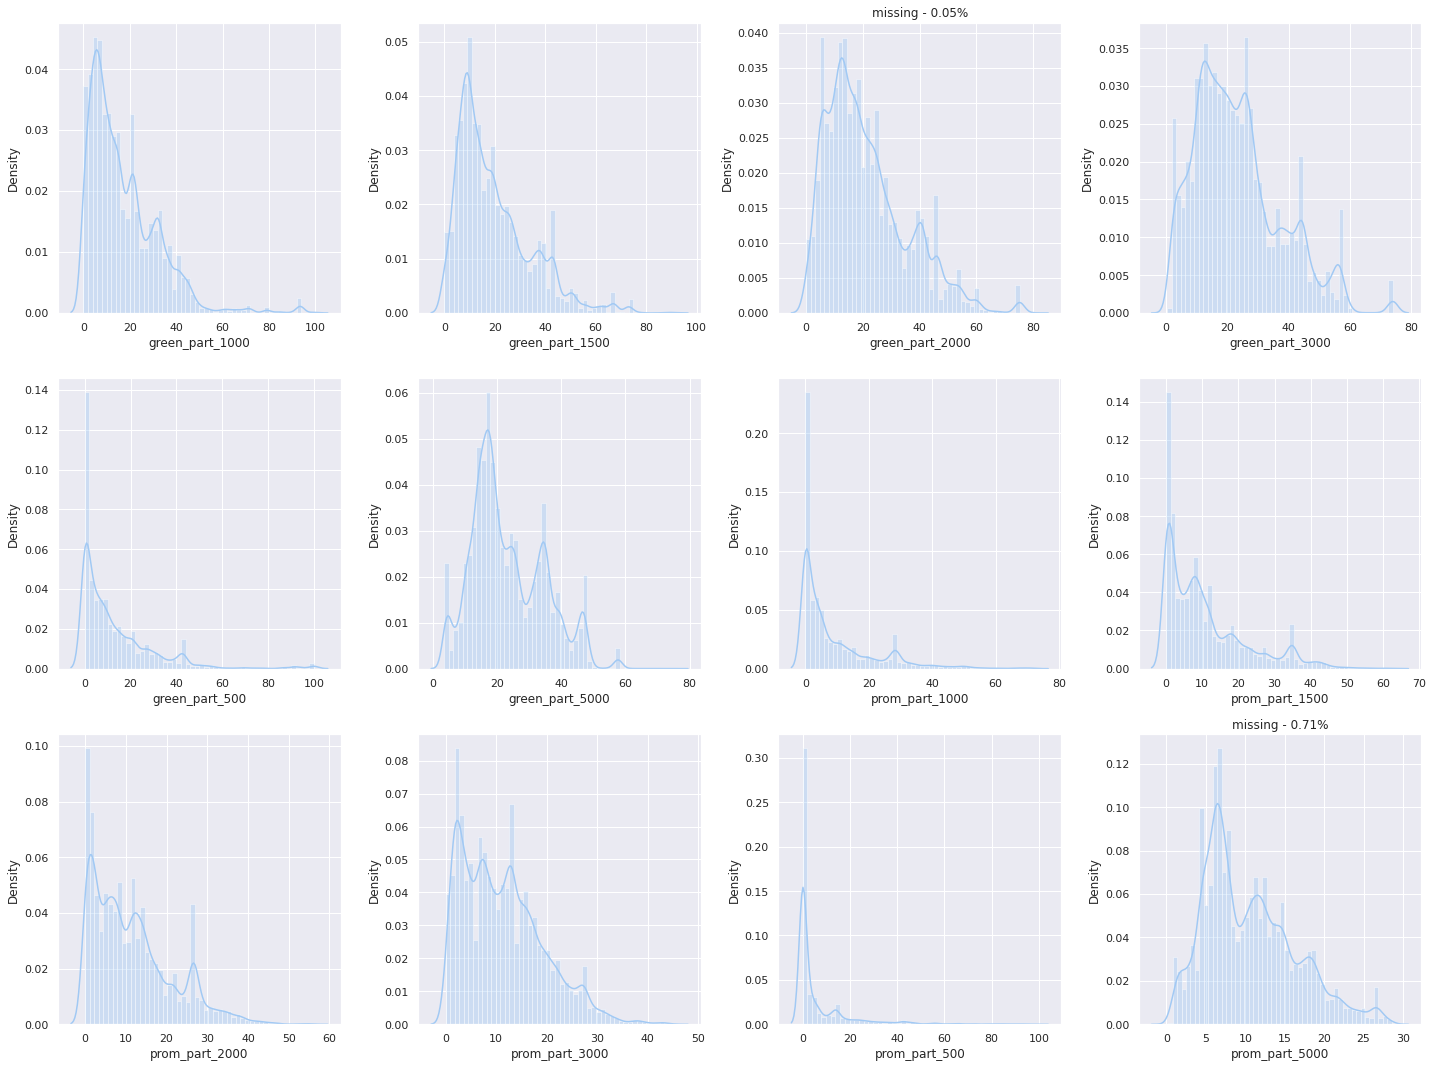

In [ ]:
cols_view(raion_features_dict['green_part']+raion_features_dict['prom_part'])

In [ ]:
missing_sub_area(raion_features_dict['green_part'])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


sub_area  %_missing
72  Nekrasovka        1.0

In [ ]:
missing_sub_area(raion_features_dict['prom_part'])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


sub_area  %_missing
96   Poselenie Novofedorovskoe       94.8
99         Poselenie Rogovskoe       83.8
138                 Vostochnoe        8.3

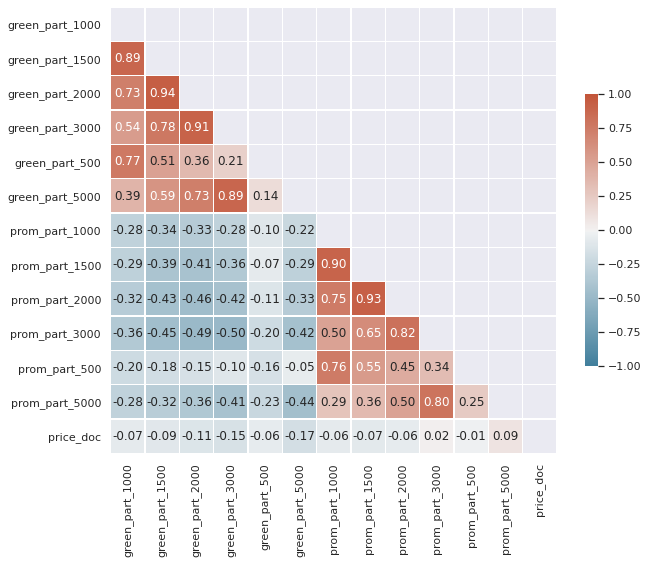

In [ ]:
heatmap_data=df[raion_features_dict['green_part']+raion_features_dict['prom_part']+target].corr()
plot_corr_matrix(heatmap_data,fmt='.2f')

#### leisure
* **'leisure_count_X'**  Количество мест отдыха в X-метровой зоне

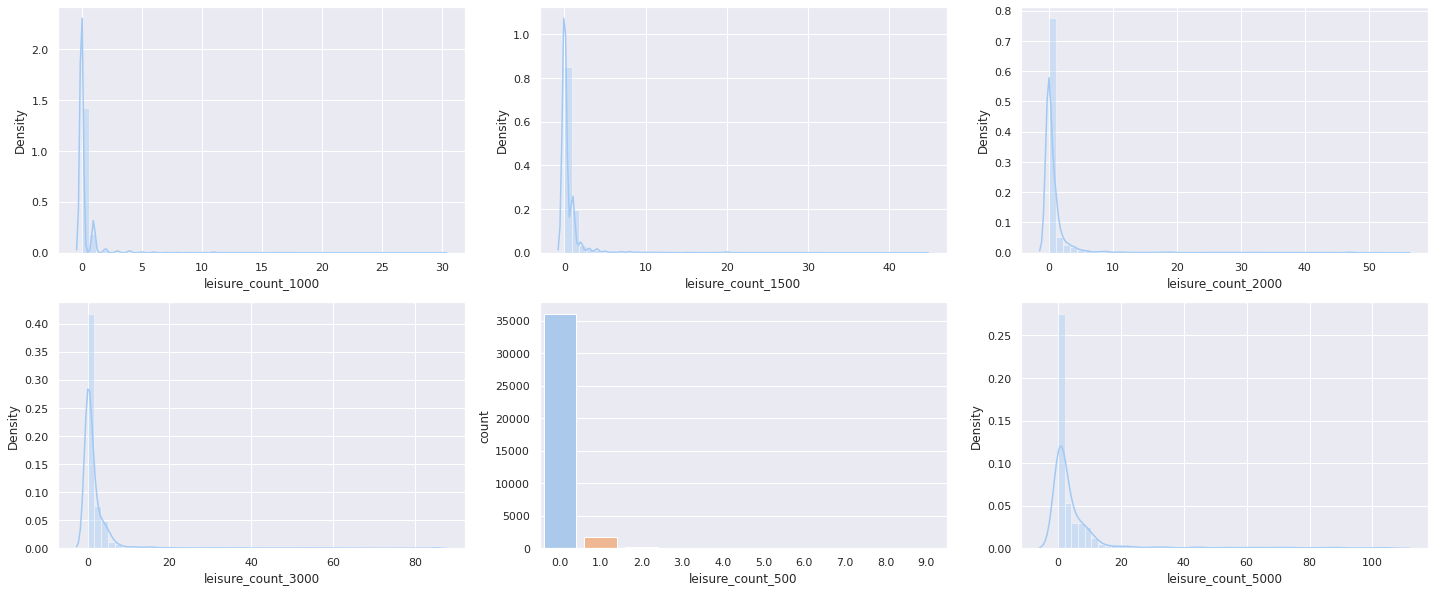

In [ ]:
cols_view(raion_features_dict['leisure'], figsize=(20,12))

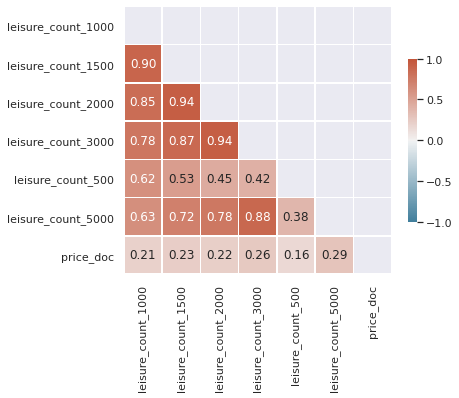

In [ ]:
heatmap_data=df[raion_features_dict['leisure']+target].corr()
plot_corr_matrix(heatmap_data,figsize=(6,6),fmt='.2f')

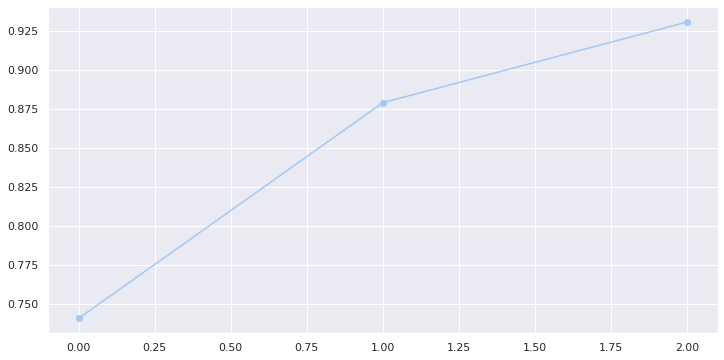

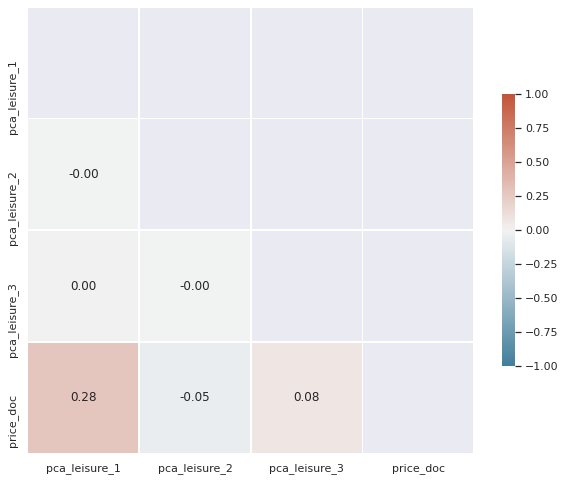

In [ ]:
df_pca=PCA_group_features(raion_features_dict['leisure'],n_components=3)

In [ ]:
# df.drop(raion_features_dict['leisure'],axis=1,inplace=True)
# df=pd.concat([df,df_pca],axis=1)

#### mosque
*   **'mosque_count_X'** Количество мечетей в X-метровой зоне
*   **'mosque_km'** Расстояние до мечети



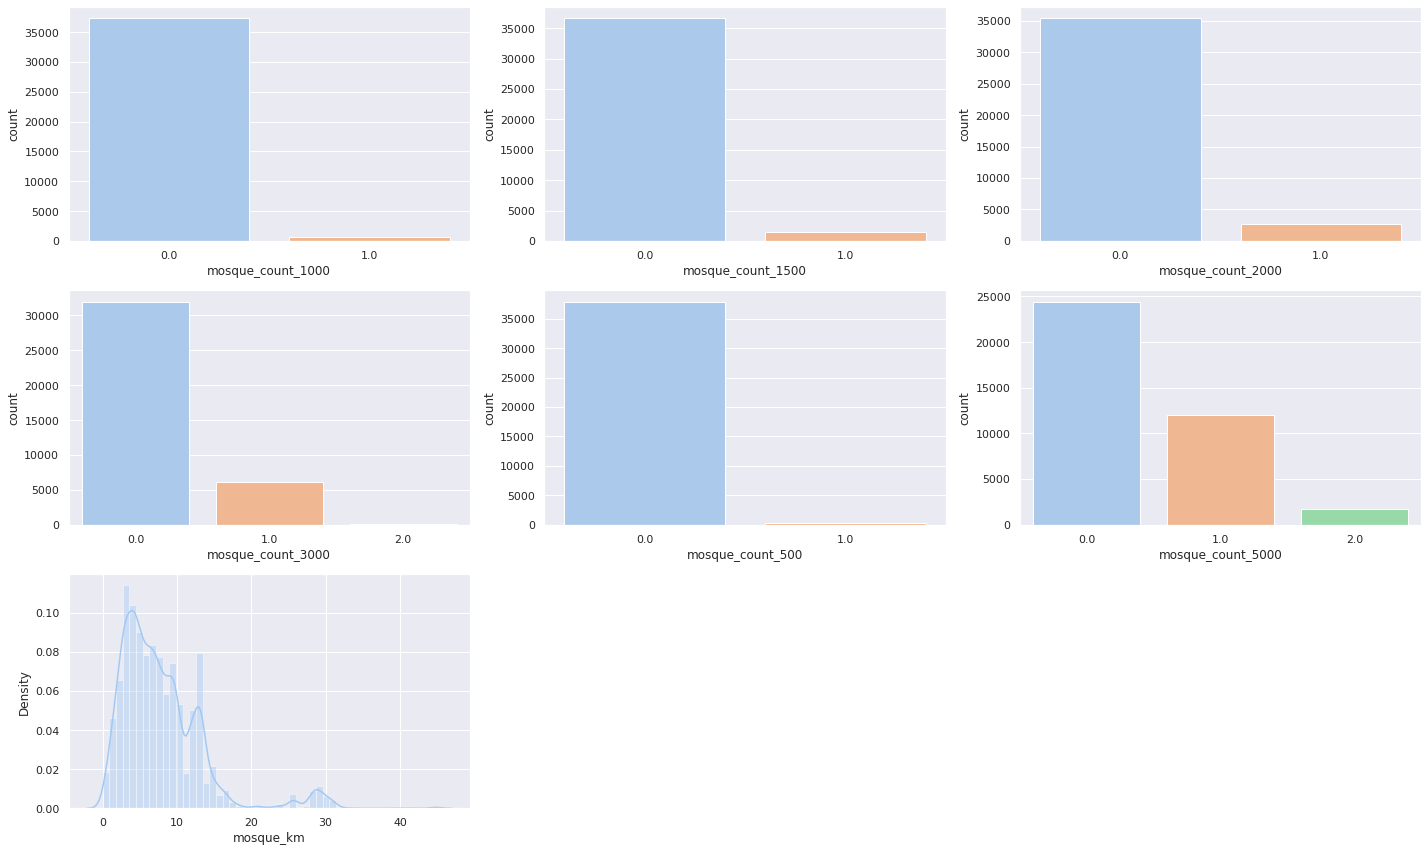

In [ ]:
cols_view(raion_features_dict['mosque'], figsize=(20,12))

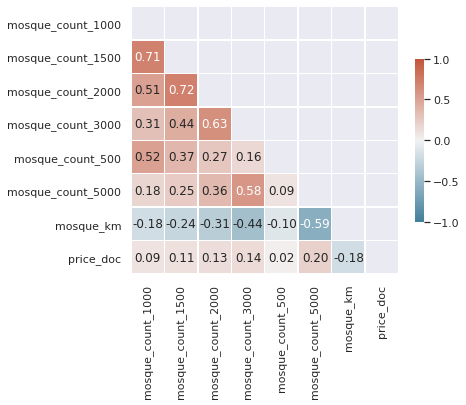

In [ ]:
heatmap_data=df[raion_features_dict['mosque']+target].corr()
plot_corr_matrix(heatmap_data,figsize=(6,6),fmt='.2f')

In [ ]:
# df_pca=PCA_group_features(raion_features_dict['mosque'],n_components=3)

In [ ]:
# df.drop(raion_features_dict['mosque'],axis=1,inplace=True)
# df=pd.concat([df,df_pca],axis=1)

#### all_male_female
*   **'X_Y_all'** Население в возрасте от X до Y лет
*   **'X_Y_female'** Женское население в возрасте от X до Y лет
*   **'X_Y_male'** Мужское население в возрасте от X до Y лет
*   **'ekder_'** Население старше трудоспособного возраста
*   **'work_'** Трудоспособное население
*   **'young_'** Население моложе трудоспособного возраста
*  **'full_all'** Общая численность населения в муниципальном
образовании 
*  **'male_f'** Мужское население
*  **'female_f'** Женское население

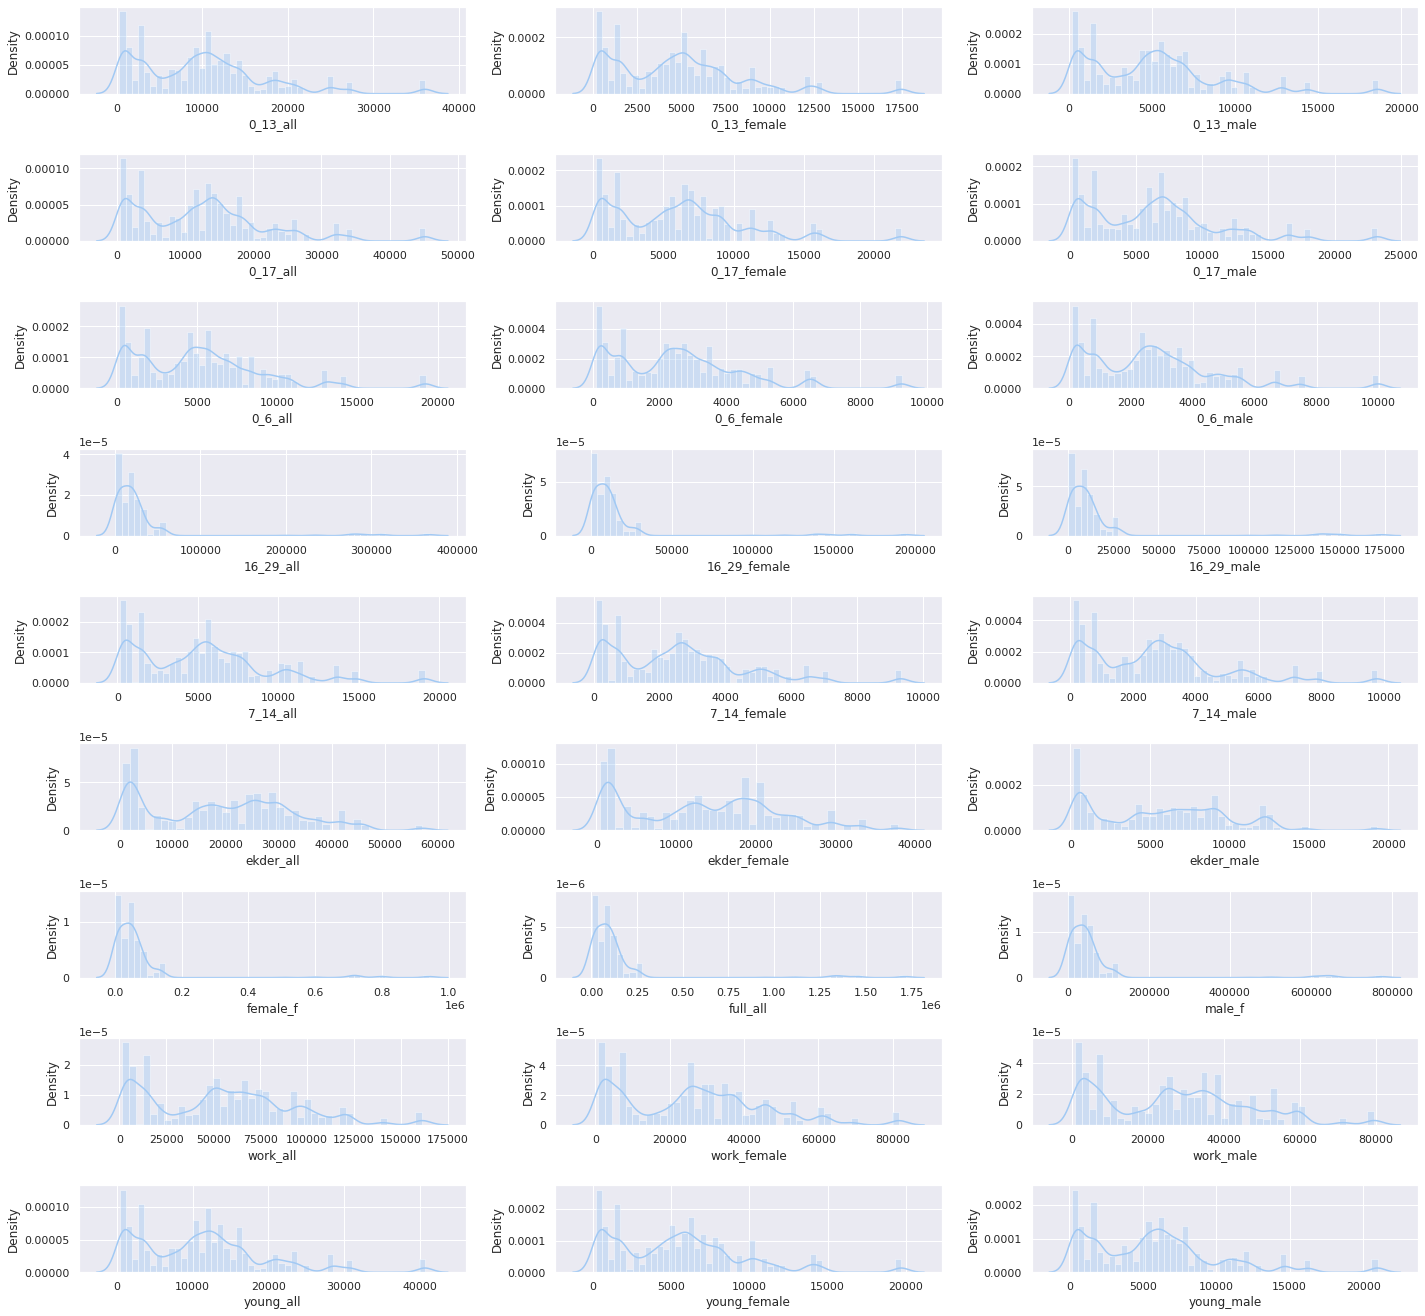

In [ ]:
cols_view(raion_features_dict['all_m_f'], figsize=(20,20))

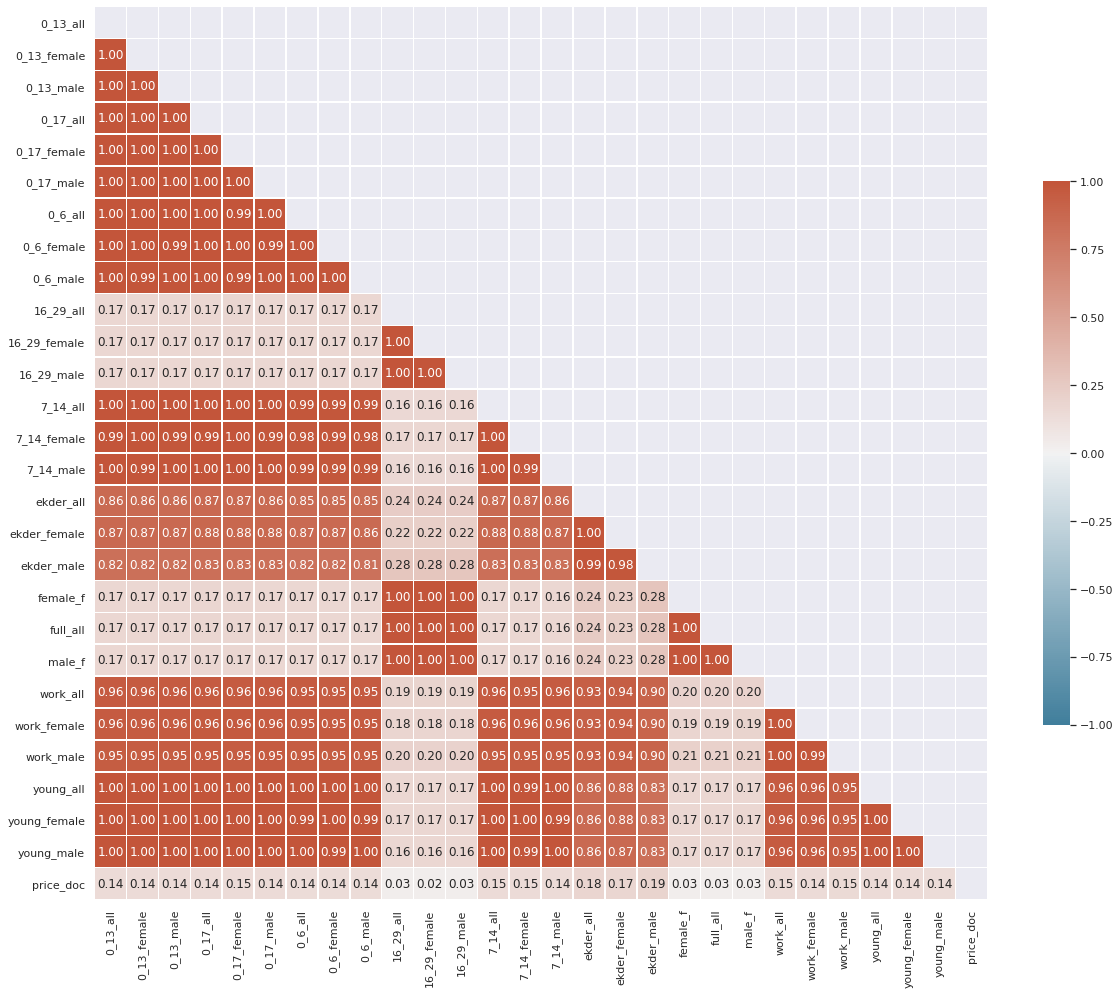

In [ ]:
heatmap_data=df[raion_features_dict['all_m_f']+target].corr()
plot_corr_matrix(heatmap_data,figsize=(20,20),fmt='.2f')

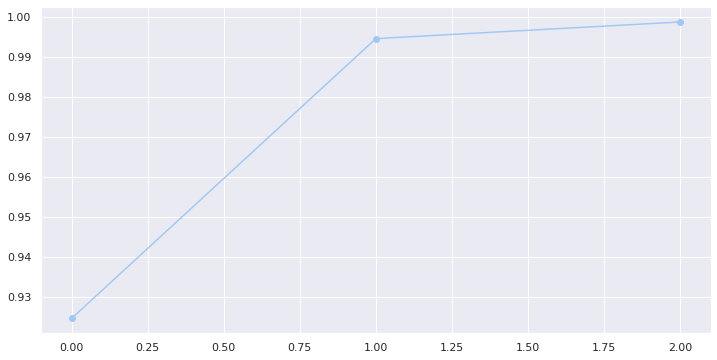

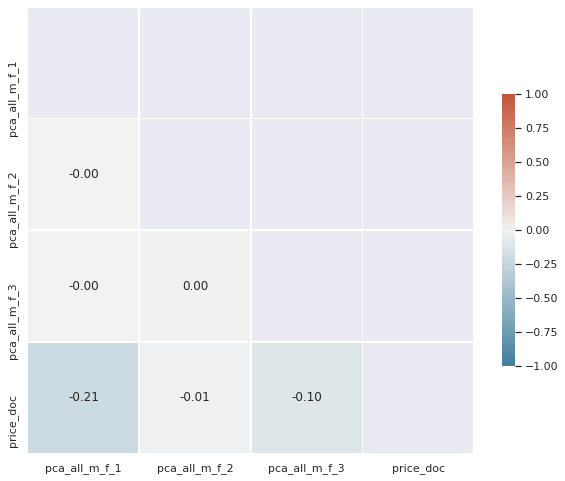

In [ ]:
df_pca=PCA_group_features(raion_features_dict['all_m_f'],n_components=3)

In [ ]:
df.drop(raion_features_dict['all_m_f'],axis=1,inplace=True)
df=pd.concat([df,df_pca],axis=1)

#### raion_features_min

In [ ]:
len(raion_features_min)

64

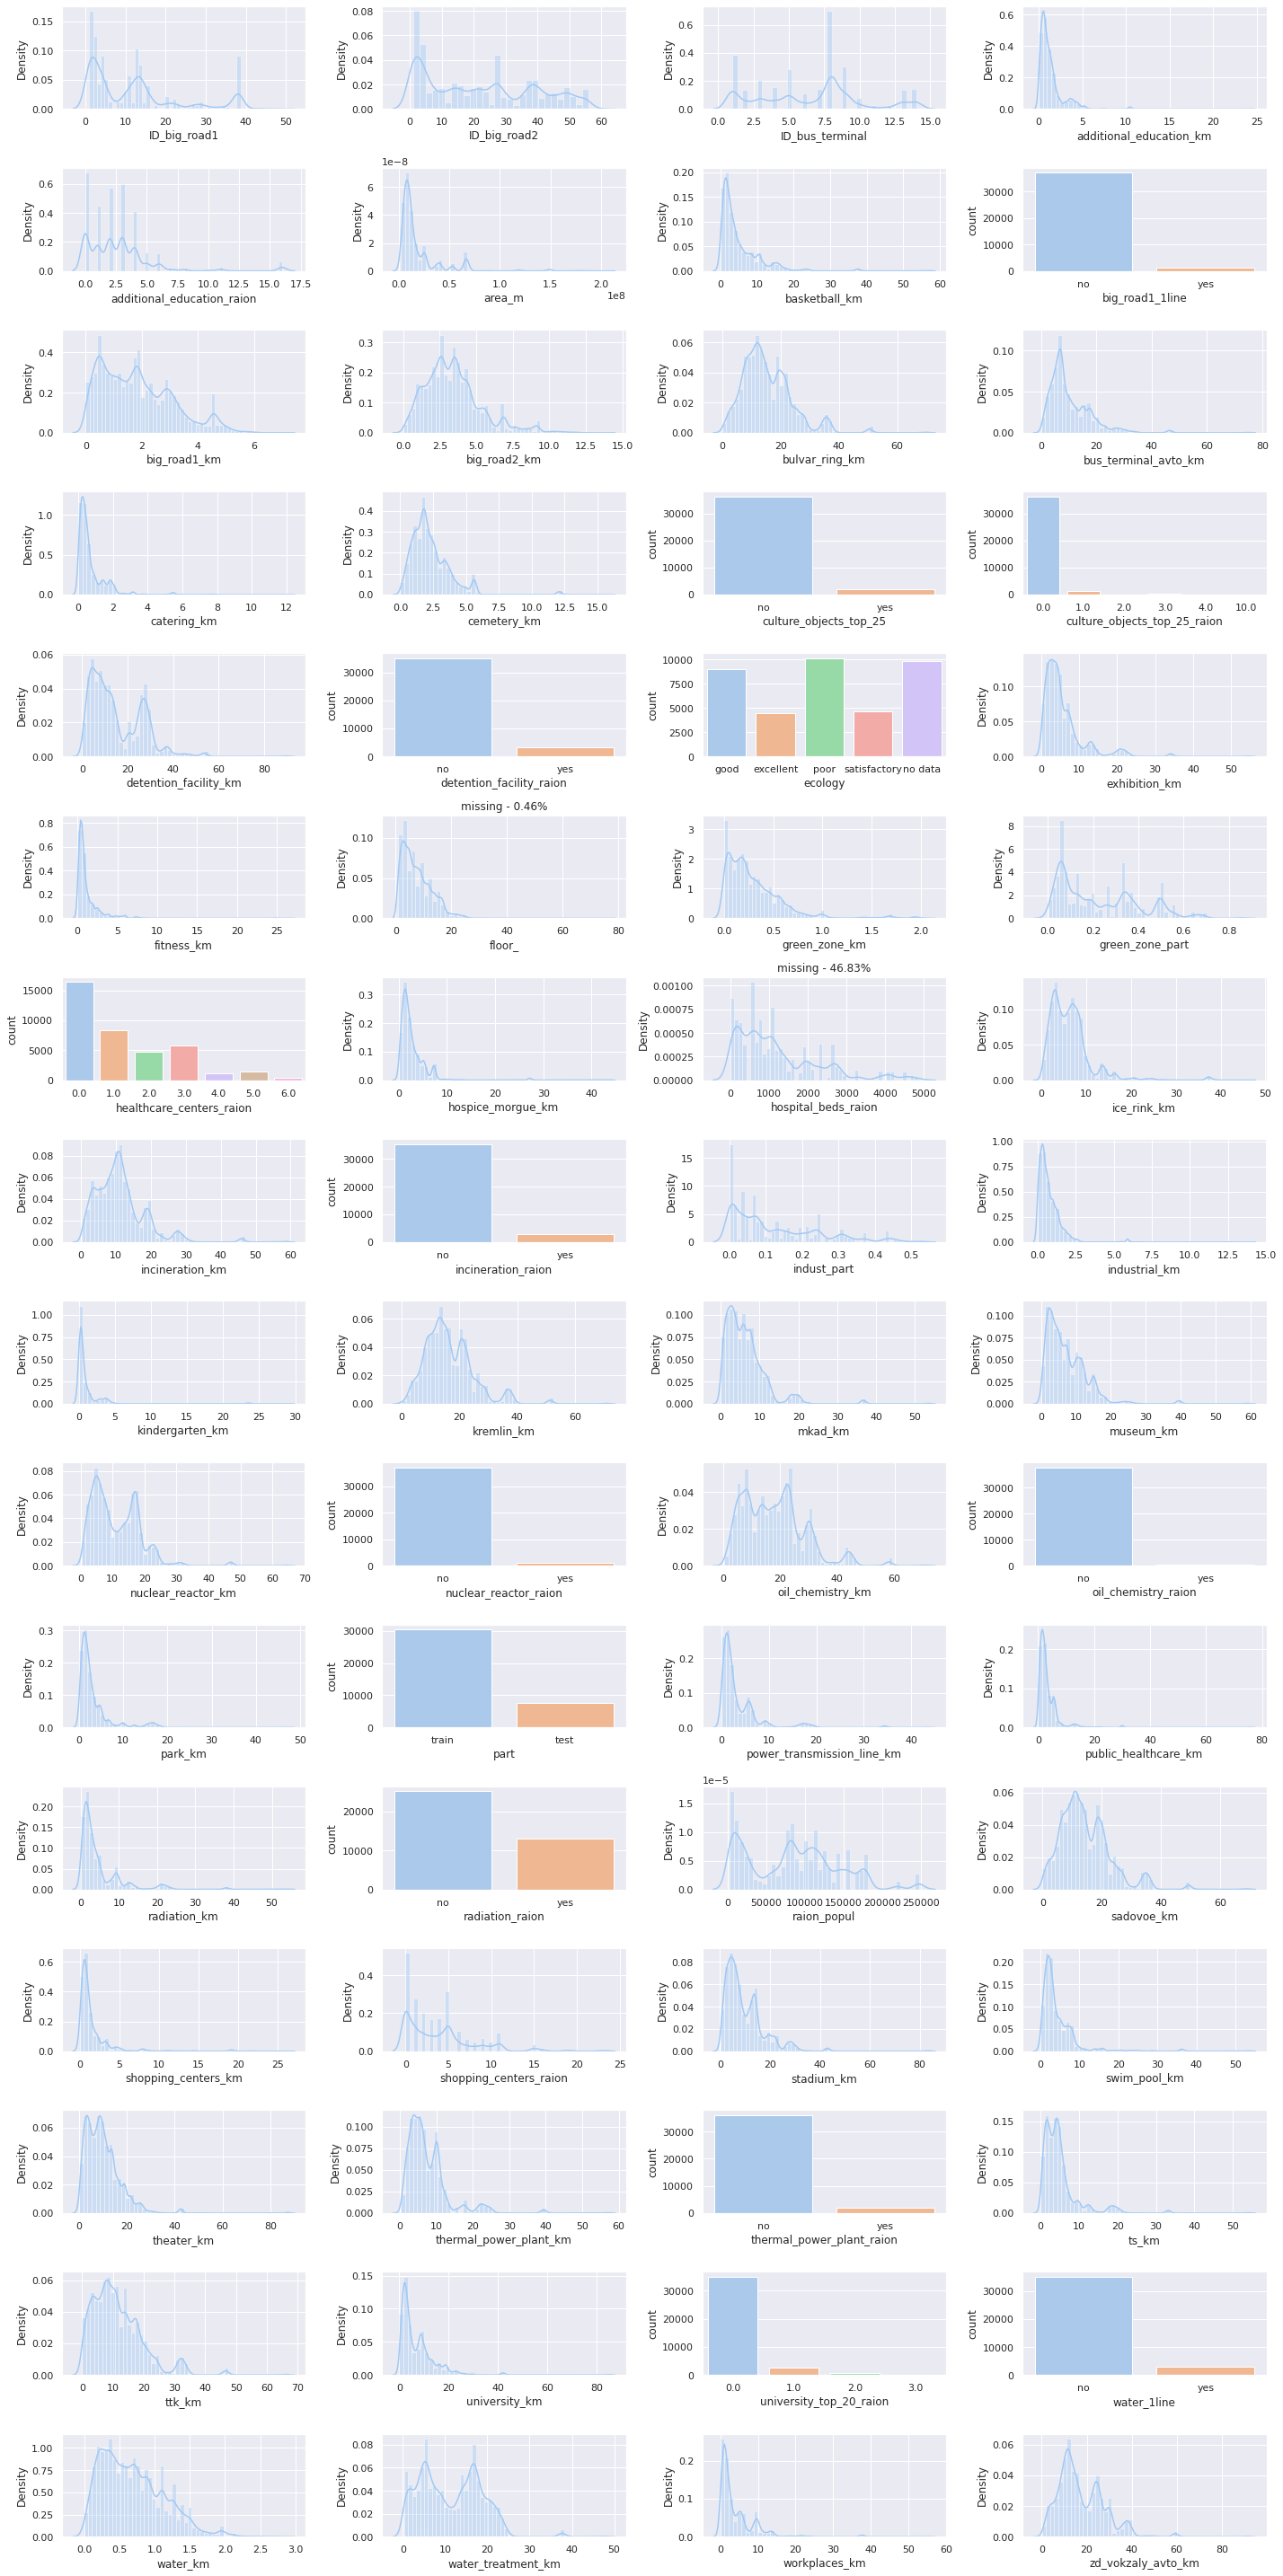

In [ ]:
cols_view(raion_features_min, figsize=(20,40))

In [ ]:
missing_sub_area(raion_features_min)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


sub_area  %_missing
3            Altuf'evskoe       50.0
5           Babushkinskoe        1.0
8         Beskudnikovskoe        1.0
10   Birjulevo Vostochnoe        0.5
11     Birjulevo Zapadnoe       50.4
..                    ...        ...
141      Vyhino-Zhulebino        0.2
142        Zamoskvorech'e        0.7
143     Zapadnoe Degunino        0.1
144            Zjablikovo        0.3
145               Zjuzino        0.3

[100 rows x 2 columns]

In [ ]:
#df['hospital_beds_raion'] = df.groupby('sub_area')['hospital_beds_raion'].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [ ]:
df.shape

(38133, 193)

### macro_features

In [ ]:
df_macro.shape

(2484, 100)

In [ ]:
df_macro['timestamp'] = pd.to_datetime(df_macro['timestamp'])
df_macro.dtypes.value_counts()

float64           94
object             3
int64              2
datetime64[ns]     1
dtype: int64

In [ ]:
df_macro.describe(include=[np.object])

child_on_acc_pre_school modern_education_share old_education_build_share
count                     1826                   1095                      1095
unique                       5                      3                         3
top                      7,311                  90,92                    8,2517
freq                       366                    365                       365

In [ ]:
for col in df_macro.columns:
    pct_missing = np.mean(df_macro[col].isnull())
    if pct_missing != 0:
        print('{} - {}%'.format(col, round(pct_missing*100,2)))

gdp_quart - 3.62%
gdp_quart_growth - 3.62%
cpi - 1.25%
ppi - 1.25%
gdp_deflator - 14.69%
balance_trade - 1.25%
balance_trade_growth - 3.62%
usdrub - 0.12%
eurrub - 0.12%
brent - 0.12%
net_capital_export - 15.94%
average_provision_of_build_contract_moscow - 14.69%
rts - 0.4%
micex - 0.4%
micex_rgbi_tr - 0.4%
micex_cbi_tr - 0.04%
deposits_growth - 1.25%
deposits_rate - 16.67%
mortgage_growth - 14.69%
grp - 26.49%
grp_growth - 41.18%
income_per_cap - 11.8%
real_dispos_income_per_cap_growth - 26.49%
salary - 11.8%
salary_growth - 26.49%
retail_trade_turnover - 11.8%
retail_trade_turnover_per_cap - 11.8%
retail_trade_turnover_growth - 11.8%
labor_force - 11.8%
unemployment - 11.8%
employment - 11.8%
invest_fixed_capital_per_cap - 11.8%
invest_fixed_assets - 11.8%
profitable_enterpr_share - 26.49%
unprofitable_enterpr_share - 26.49%
share_own_revenues - 26.49%
overdue_wages_per_cap - 26.49%
fin_res_per_cap - 26.49%
marriages_per_1000_cap - 26.49%
divorce_rate - 26.49%
construction_value - 26

#Train,test

In [ ]:
df_all=df.merge(df_macro, on='timestamp',right_index=True)
df_all.drop(['timestamp'],axis=1,inplace=True)
df_all.shape

(38133, 291)

In [ ]:
cut_columns_list = df_all.select_dtypes(include='object').columns.tolist()
cut_columns_list

['material',
 'product_type',
 'sub_area',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'water_1line',
 'big_road1_1line',
 'railroad_1line',
 'ecology',
 'part',
 'child_on_acc_pre_school',
 'modern_education_share',
 'old_education_build_share']

In [ ]:
df_all[cut_columns_list]=df_all[cut_columns_list].fillna('no_info')

In [ ]:
train=df_all[(df_all['part']=='train')]
test=df_all[(df_all['part']=='test')].drop(['price_doc'], axis=1)

In [ ]:
train.shape

(30471, 291)

In [ ]:
test.shape

(7662, 290)

In [ ]:
y=np.log(train['price_doc'])
X=train.drop(['price_doc'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#price_for_meter = train['price_doc']/(train['full_sq']+1)*1e6
## part: Investment
idx_i = train['product_type']=='Investment'
bad_idx = train[idx_i &(price_for_meter< 45000)].index
train.drop(bad_idx,inplace=True)

y_t1 = np.log(train[idx_i]['price_doc'])
X_t1 = train[idx_i].drop(['price_doc','suspicious_offer'], axis=1)
# split
X_t1_train, X_t1_valid, y_t1_train, y_t1_valid = train_test_split(X_t1, y_t1, test_size=0.2, random_state=42)


## part: OwnerOccupier
idx_o = train['product_type']=='OwnerOccupier'
bad_idx = train[idx_o &(price_for_meter< 45000)].index
train.drop(bad_idx,inplace=True)

y_t2 = np.log(train[idx_o]['price_doc'])
X_t2 = train[idx_o].drop(['price_doc','suspicious_offer'], axis=1)
# split
X_t2_train, X_t2_valid, y_t2_train, y_t2_valid = train_test_split(X_t2, y_t2, test_size=0.2, random_state=42)

Boolean Series key will be reindexed to match DataFrame index.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
train.shape

(28584, 291)

# CatBoost

In [ ]:
! pip install catboost

In [ ]:
!pip install shap

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
import shap

In [ ]:
path = '/content/dataset/sberbank-russian-housing-market/cat_results'
path

'/content/dataset/sberbank-russian-housing-market/cat_results'

### CatBoost for all

In [ ]:
cat = CatBoostRegressor(
    cat_features=cut_columns_list, 
    nan_mode='Min',
    objective="RMSE",
    iterations=1000, 
    verbose=200,
    #task_type='GPU',
    train_dir=path,
    )

In [ ]:
cat.fit(X_train,y_train)

Learning rate set to 0.06891
0:	learn: 0.5753030	total: 193ms	remaining: 3m 12s
200:	learn: 0.2156179	total: 18.3s	remaining: 1m 12s
400:	learn: 0.1994218	total: 36s	remaining: 53.8s
600:	learn: 0.1883736	total: 53.8s	remaining: 35.7s
800:	learn: 0.1785291	total: 1m 11s	remaining: 17.7s
999:	learn: 0.1704282	total: 1m 29s	remaining: 0us


In [ ]:
#RMSLE(valid dataset): 0.17359927623951862
y_pred=cat.predict(X_valid)
print('RMSLE(valid dataset):', np.sqrt(mean_squared_log_error(np.exp(y_valid), np.exp(y_pred))))

RMSLE(valid dataset): 0.17378613531191692


In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

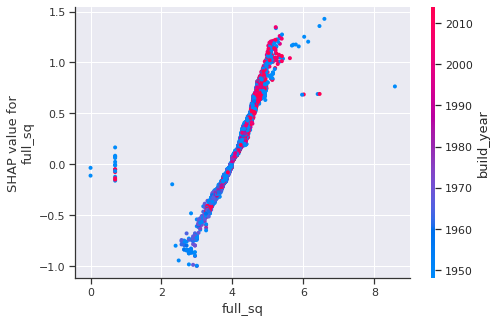

In [ ]:
shap.dependence_plot("full_sq", shap_values, X_train, interaction_index="build_year")

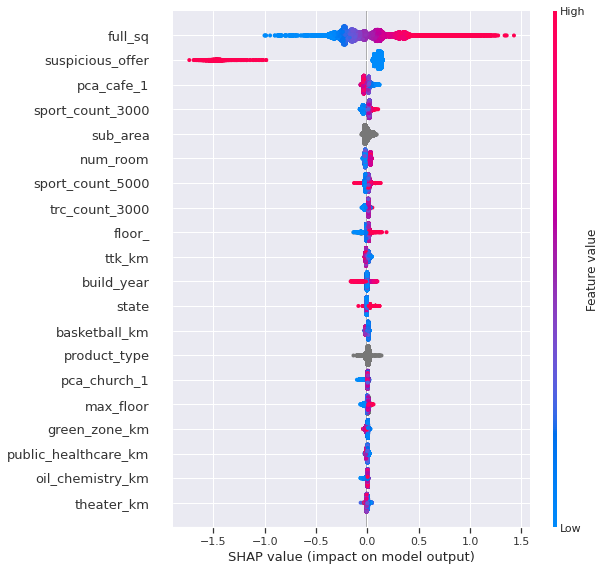

In [ ]:
shap.summary_plot(shap_values, X_train)#,plot_type="bar")

In [ ]:
# pd.DataFrame({'feature':cat.feature_names_, 'values':cat.get_feature_importance()}).sort_values(by='values',ascending=False).head(10)

In [ ]:
pred=np.exp(cat.predict(test))
pred

array([5.78187347, 9.19753931, 6.10387315, ..., 4.89607543, 4.53092215,
       9.31318666])

In [ ]:
submission = pd.DataFrame(
    {
      'id': test.index,
      'price_doc': pred*1e6
     })
submission.set_index('id')

price_doc
id                 
30474  5.781873e+06
30475  9.197539e+06
30476  6.103873e+06
30477  6.845945e+06
30478  5.379408e+06
...             ...
38131  8.371049e+06
38132  5.338673e+06
38133  4.896075e+06
38134  4.530922e+06
38135  9.313187e+06

[7662 rows x 1 columns]

In [ ]:
submission.to_csv('submission.csv', index=None)

In [ ]:
# score kaggle = 0.33276 
#!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "Second submission"

### CatBoost for 'product_type'='Investment'

In [ ]:
cut_columns_list = test.select_dtypes(include='object').columns.tolist()

In [ ]:
cat_t1 = CatBoostRegressor(
    cat_features=cut_columns_list, 
    nan_mode='Min',
    objective="RMSE",
    iterations=1000, 
    verbose=200,
    #task_type='GPU',
    train_dir=path,
    )

In [ ]:
cat_t1.fit(X_t1_train,y_t1_train)

Learning rate set to 0.062524
0:	learn: 0.4537211	total: 91.5ms	remaining: 1m 31s
200:	learn: 0.2531547	total: 13.7s	remaining: 54.3s
400:	learn: 0.2342788	total: 27.2s	remaining: 40.6s
600:	learn: 0.2203660	total: 40.6s	remaining: 26.9s
800:	learn: 0.2088486	total: 54s	remaining: 13.4s
999:	learn: 0.1976101	total: 1m 7s	remaining: 0us


In [ ]:
#RMSLE(valid dataset): 0.2196165674582046
y_t1_pred=cat_t1.predict(X_t1_valid)
print('RMSLE(valid dataset):', np.sqrt(mean_squared_log_error(np.exp(y_t1_valid), np.exp(y_t1_pred))))

RMSLE(valid dataset): 0.21972496862451588


In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(cat_t1)
shap_values = explainer.shap_values(X_t1_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[4,:], X_t1_train.iloc[4,:])

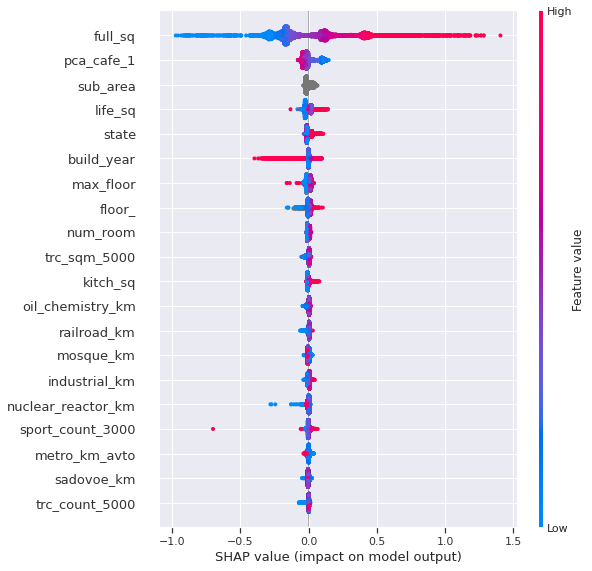

In [ ]:
shap.summary_plot(shap_values, X_t1_train)#,plot_type="bar")

In [ ]:
# pd.DataFrame({'feature':cat_t1.feature_names_, 'values':cat_t1.get_feature_importance()}).sort_values(by='values',ascending=False).head(10)

In [ ]:
test_t1=test[(test['product_type']=='Investment')|(test['product_type']=='no_info')].drop(['suspicious_offer'], axis=1)
pred_t1=np.exp(cat_t1.predict(test_t1))
pred_t1

array([ 5.87294814,  5.63302119,  5.64540229, ...,  9.69598071,
        5.62986077, 10.14639665])

In [ ]:
submission_t1 = pd.DataFrame(
    {
      'id': test_t1.index,
      'price_doc': pred_t1*1e6
     })
submission_t1.set_index('id')

price_doc
id                 
30474  5.872948e+06
30476  5.633021e+06
30482  5.645402e+06
30487  4.320747e+06
30491  2.080483e+07
...             ...
38121  5.195802e+06
38125  8.540969e+06
38131  9.695981e+06
38134  5.629861e+06
38135  1.014640e+07

[5031 rows x 1 columns]

### GridSearch

In [ ]:
cat_t1_cv = CatBoostRegressor(
    cat_features=cut_columns_list, 
    nan_mode='Min',
    objective="RMSE",
    grow_policy='Lossguide',
    iterations=500, 
    verbose=200,
    #task_type='GPU',
    train_dir=path,
    )

In [ ]:
grid = {'learning_rate': [0.03, 0.1],
        #'depth': [4, 8, 16],
        #'l2_leaf_reg': [1, 3],
        'max_leaves':[16,32,64,128,256,512]
        }

grid_search_result = cat_t1_cv.grid_search(grid, X=X_t1_train, y=y_t1_train,cv=3)
grid_search_result['params']


bestTest = 0.2634615403
bestIteration = 497

0:	loss: 0.2634615	best: 0.2634615 (0)	total: 53.2s	remaining: 9m 45s

bestTest = 0.2637021396
bestIteration = 244

1:	loss: 0.2637021	best: 0.2634615 (0)	total: 1m 47s	remaining: 8m 55s

bestTest = 0.2624480495
bestIteration = 499

2:	loss: 0.2624480	best: 0.2624480 (2)	total: 3m 2s	remaining: 9m 6s

bestTest = 0.2633778752
bestIteration = 239

3:	loss: 0.2633779	best: 0.2624480 (2)	total: 4m 20s	remaining: 8m 40s

bestTest = 0.2620801605
bestIteration = 498

4:	loss: 0.2620802	best: 0.2620802 (4)	total: 5m 54s	remaining: 8m 15s

bestTest = 0.2636844092
bestIteration = 164

5:	loss: 0.2636844	best: 0.2620802 (4)	total: 7m 26s	remaining: 7m 26s

bestTest = 0.2620801605
bestIteration = 498

6:	loss: 0.2620802	best: 0.2620802 (4)	total: 8m 59s	remaining: 6m 25s

bestTest = 0.2636844092
bestIteration = 164

7:	loss: 0.2636844	best: 0.2620802 (4)	total: 10m 30s	remaining: 5m 15s

bestTest = 0.2620801605
bestIteration = 498

8:	loss: 0.2620802	b

{'learning_rate': 0.03, 'max_leaves': 64}

In [ ]:
#RMSLE(valid dataset): 0.21946290342762115
y_t1_cv_pred=cat_t1_cv.predict(X_t1_valid)
print('RMSLE(valid dataset):', np.sqrt(mean_squared_log_error(np.exp(y_t1_valid), np.exp(y_t1_cv_pred))))

RMSLE(valid dataset): 0.2184875304677882


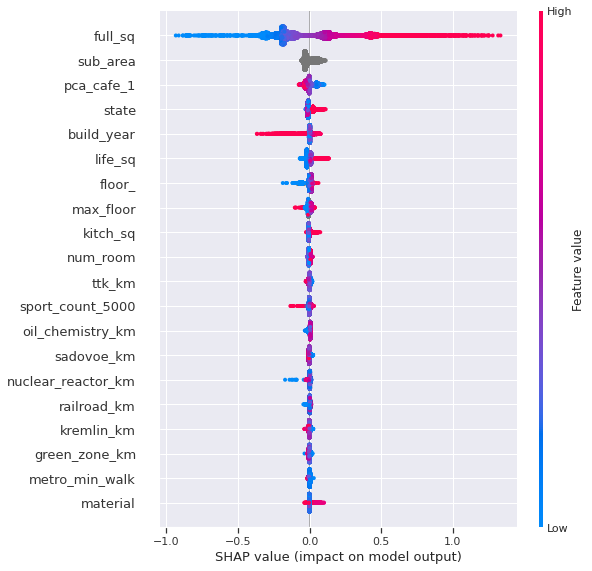

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(cat_t1_cv)
shap_values = explainer.shap_values(X_t1_train)
shap.summary_plot(shap_values, X_t1_train)

In [ ]:
test_t1=test[(test['product_type']=='Investment')|(test['product_type']=='no_info')].drop(['suspicious_offer'], axis=1)
pred_t1_cv=np.exp(cat_t1_cv.predict(test_t1))
pred_t1_cv

array([5.70691021, 5.88731435, 5.33429317, ..., 9.02524622, 5.71734371,
       8.99373878])

In [ ]:
submission_t1_cv = pd.DataFrame(
    {
      'id': test_t1.index,
      'price_doc': pred_t1_cv*1e6
     })
submission_t1_cv.set_index('id')

price_doc
id                 
30474  5.706910e+06
30476  5.887314e+06
30482  5.334293e+06
30487  4.498618e+06
30491  1.960123e+07
...             ...
38121  4.992821e+06
38125  8.644068e+06
38131  9.025246e+06
38134  5.717344e+06
38135  8.993739e+06

[5031 rows x 1 columns]

### CatBoost for 'product_type'='OwnerOccupier'

In [ ]:
cat_t2 = CatBoostRegressor(
    cat_features=cut_columns_list, 
    nan_mode='Min',
    objective="RMSE",
    iterations=1000, 
    verbose=200,
    #task_type='GPU',
    train_dir=path,
    )

In [ ]:
cat_t2.fit(X_t2_train,y_t2_train)

Learning rate set to 0.057422
0:	learn: 0.4290503	total: 95.5ms	remaining: 1m 35s
200:	learn: 0.0925334	total: 10.8s	remaining: 43s
400:	learn: 0.0745961	total: 21.5s	remaining: 32s
600:	learn: 0.0654366	total: 32.2s	remaining: 21.4s
800:	learn: 0.0593501	total: 42.9s	remaining: 10.7s
999:	learn: 0.0544638	total: 53.7s	remaining: 0us


In [ ]:
#RMSLE(valid dataset): 0.07368250599069698
y_t2_pred=cat_t2.predict(X_t2_valid)
print('RMSLE(valid dataset):', np.sqrt(mean_squared_log_error(np.exp(y_t2_valid), np.exp(y_t2_pred))))

RMSLE(valid dataset): 0.07343098825116608


In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(cat_t2)
shap_values = explainer.shap_values(X_t1_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[99,:], X_t1_train.iloc[99,:])

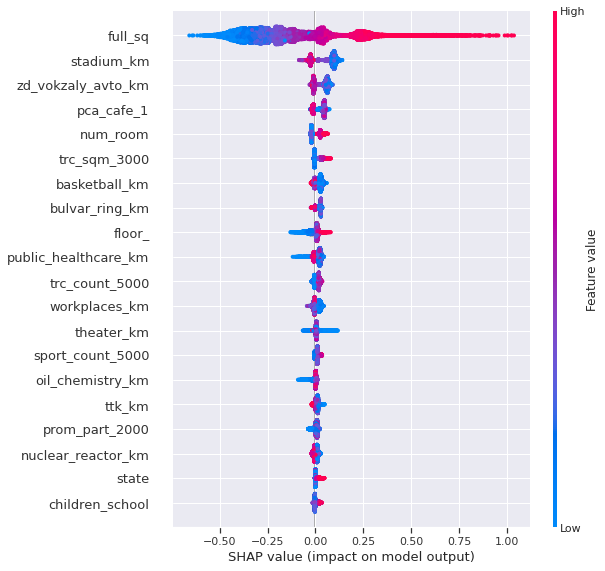

In [ ]:
shap.summary_plot(shap_values, X_t1_train)#,plot_type="bar")

In [ ]:
# pd.DataFrame({'feature':cat_t2.feature_names_, 'values':cat_t2.get_feature_importance()}).sort_values(by='values',ascending=False).head(10)

In [ ]:
test_t2=test[(test['product_type']=='OwnerOccupier')].drop(['suspicious_offer'], axis=1)
pred_t2=np.exp(cat_t2.predict(test_t2))
pred_t2

array([8.63974731, 6.9567909 , 5.31308832, ..., 5.13936598, 4.98068662,
       4.22436856])

In [ ]:
submission_t2 = pd.DataFrame(
    {
      'id': test_t2.index,
      'price_doc': pred_t2*1e6
     })
submission_t2.set_index('id')

price_doc
id                 
30475  8.639747e+06
30477  6.956791e+06
30478  5.313088e+06
30479  1.002358e+07
30480  4.680284e+06
...             ...
38128  2.562989e+06
38129  3.587232e+06
38130  5.139366e+06
38132  4.980687e+06
38133  4.224369e+06

[2631 rows x 1 columns]

In [ ]:
submission_all=pd.concat([submission_t1,submission_t2])
submission_all.sort_values(by='id').set_index('id')

price_doc
id                 
30474  5.872948e+06
30475  8.639747e+06
30476  5.633021e+06
30477  6.956791e+06
30478  5.313088e+06
...             ...
38131  9.695981e+06
38132  4.980687e+06
38133  4.224369e+06
38134  5.629861e+06
38135  1.014640e+07

[7662 rows x 1 columns]

In [ ]:
submission_all.to_csv('submission.csv', index=None)

In [ ]:
# score kaggle = 0.32677
#!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "Second submission for type"

In [ ]:
submission_all=pd.concat([submission_t1_cv,submission_t2])
submission_all.sort_values(by='id').set_index('id')

price_doc
id                 
30474  5.706910e+06
30475  8.639747e+06
30476  5.887314e+06
30477  6.956791e+06
30478  5.313088e+06
...             ...
38131  9.025246e+06
38132  4.980687e+06
38133  4.224369e+06
38134  5.717344e+06
38135  8.993739e+06

[7662 rows x 1 columns]

In [ ]:
submission_all.to_csv('submission.csv', index=None)

In [ ]:
# score kaggle = 0.32481
#!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "Second submission for type grid_search"

100% 181k/181k [00:02<00:00, 62.2kB/s]
Successfully submitted to Sberbank Russian Housing Market